# Plot Results from Simulation

In [1]:
cd ..

/ihome/ltang/ziz60/nmf_causal_eval


In [2]:
from helper_functions import find_matched_topic_index, reorder_U_val, reorder_V_val, reorder_beta_val, generate_cor_df, custom_pearsonr, reorder_U, reorder_V, reorder_beta,vec2col, generate_data_dlearning,pos, neg, NNDSVD, vec2col, error_plot,find_optimal_r

from evaluation import eval_ITR

from joblib import dump, load
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


import numpy as np

import os
from matplotlib.backends.backend_pdf import PdfPages


import time
from numpy.random import rand
from numpy import exp, log, mat
from numpy.linalg import norm
from scipy.io import loadmat
from scipy.linalg import svd 
from array import array
import pandas as pd


import math
from itertools import permutations #used in find_matched_topic_index


from sklearn.decomposition import NMF # Used in two-stage NMF
#from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split #for cross validation


## my functions
#from helper_functions import pos, neg, NNDSVD, vec2col, error_plot

#from sklearn.metrics import adjusted_rand_score
#from helper_functions_eval import reorder_U_val, reorder_U, reorder_V, reorder_beta,vec2col, generate_data_dlearning,pos, neg, NNDSVD, vec2col, error_plot,find_optimal_r
#from evaluation import eval_ITR, find_matched_topic_index, eval_overall_congruence,eval_topic_congruence, eval_ari, eval_topic_selection,Dlearn_SNMF_eval 
from evaluation import eval_ITR
from PGD_Dlearning_v3 import objective_function, objective_U, objective_V, objective_b2, subprob_U, subprob_V, subprob_b2, gradient_descent
from PGD_Dlearning_test import gradient_descent_test

from sklearn.linear_model import LogisticRegression


from itertools import permutations

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm

import time
from datetime import datetime

# Define a function to assign max_corr_topic for each group
def assign_max_corr_topic(group):
    # Sort the group by 'value' column in descending order
    group_sorted = group.sort_values(by='value', ascending=False)
    
    # Assign max_corr_topic for each row
    group_sorted['max_corr_topic'] = range(1, R+1)
        
    return group_sorted

import warnings


def count_matches(perm, df, choices):
    column_name = "m"
    for choice in perm:
        column_name += str(choice)
        conditions = [df["topic_hat"] == int(choice)]
        df[column_name] = np.select(conditions, choices, default=np.nan)
    columns_to_check = df.columns[2:]

    counts = []
    for column_name in columns_to_check:
        count = len(df[df['topic_true'] == df[column_name]])
        counts.append(count)
    return max(counts), perm
        
def largest_absolute_indices(arr, k):
    # Get the indices that would sort the absolute values of the array in descending order
    sorted_indices = np.argsort(np.abs(arr))[::-1]

    # Select the first r indices
    largest_indices = sorted_indices[:k]
    # Convert indices to a Python list
    largest_indices_list = largest_indices.tolist()
    return largest_indices_list


def plot(word_key, convergence_step, V_ls, ax=None):
    word_ls = []
    for i in range(convergence_step):
        word = V_ls[i][:, word_key-1]  # Assuming word_key is 1-indexed
        word = word.reshape(-1, 1)
        word_ls.append(word)

    word_df = np.hstack(word_ls)  
    word_df = pd.DataFrame(word_df.T, columns=['T1', 'T2', 'T3', 'T4', 'T5'])
    word_df['iteration'] = range(convergence_step)
    word_df_long = word_df.melt(id_vars='iteration', var_name='topic', value_name='V')

    # Create the line plot
    if ax is None:
        fig, ax = plt.subplots()
    sns.lineplot(data=word_df_long, x='iteration', y='V', hue='topic', marker=None, ax=ax, legend=None)

    # Add title and labels
    ax.set_title(f'Word {word_key+1}')
    ax.set_xlabel('Iteration')
    ax.set_ylim(-0.1, 1.5)


#from plot import plot_V, plot_tuning,plot_tmt_propensity

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

from joblib import dump, load



def plot_X2(X2, U, V, k, standardize):
    # For each document (row) in U, identify the topic# that the document is mainly discussing.
    # Initialize an empty list to store the results
    sample_order_df = []

    # Loop through each row in U
    for i in range(U.shape[0]):
        # Extract the i-th row as a dataframe
        U_i = pd.DataFrame(U.iloc[i]).reset_index(drop=True)
        # Add a 'topic' column with index values
        U_i['topic'] = range(len(U_i))
        U_i = U_i.sort_values(by=U_i.columns[0], ascending=False)# Sort by the first column in descending order
        U_i_top_1 = U_i.head(1)# Get the top 1 row (highest value)
        # Get the top topic index (topic_i)
        topic_i = U_i_top_1['topic'].values[0]
        # Append the results as a tuple (i, topic_i)
        sample_order_df.append((i, topic_i))
    # Convert the list of results into a dataframe
    sample_order_df = pd.DataFrame(sample_order_df, columns=['i', 'topic'])

    # Display the resulting dataframe
    sample_order_df=sample_order_df.sort_values(by=sample_order_df.columns[1], ascending=True)
    #!!!this is used to reorder X2
    ordered_indices = sample_order_df['i'].values 

    #!!!this is used to plot the partition lines
    freq_tb = sample_order_df['topic'].value_counts().reset_index()
    freq_tb=freq_tb.sort_values(by=freq_tb.columns[0], ascending=True)


    ################################ plot
    R = V.shape[0]  # Number of columns in V
    n = X2.shape[0]
    X2_new = np.empty((n, 0))  # Initialize an empty array to store the results
    all_top_k_dfs = []
    for topic_i in range(R):
        V_i = pd.DataFrame(V.iloc[topic_i])  # Get the i-th row of V (all words for topic_i)
        V_i['index'] = range(len(V_i))  # Add an index column
        V_i = V_i.sort_values(by=V_i.columns[0], ascending=False)  # Sort by the values in the topic column
        V_i_top_k = V_i.head(k)  # Get the top k rows
        top_k_index = V_i_top_k['index'].values  # Get the index of these top k rows

        # this is for output df
        V_i_top_k_df = V_i_top_k
        V_i_top_k_df = V_i_top_k_df.rename(columns={topic_i: "value", "index": "word_index"})

        V_i_top_k_df['topic'] = topic_i
        
        all_top_k_dfs.append(V_i_top_k_df)
        
        # Select the corresponding columns from X2 using top_k_index
        X2_i = X2[:, top_k_index]

        if standardize == True:
            X2_i = X2_i/np.linalg.norm(X2_i)
        
        # Concatenate the results column-wise
        X2_new = np.concatenate((X2_new, X2_i), axis=1)

    V_top_k_df = pd.concat(all_top_k_dfs, ignore_index=True)
    # X2_new now contains the column-combined X2_i for all topics
    X2_new_ordered = X2_new[ordered_indices, :]

    # Create the heatmap
    plt.figure(figsize=(5, 10))

    sns.heatmap(X2_new_ordered, cmap="Blues")

    # Get the number of rows and columns in X2_new_ordered
    n_rows, n_cols = X2_new_ordered.shape

    # Add 5 vertical lines equally spaced across the heatmap
    for i in range(1, 5):  # 5 partitions create 6 sections
        plt.axvline(x=n_cols * i / 5, color='orange', linestyle='--', linewidth=0.7)

    # Add horizontal lines based on the frequencies in freq_tb
    # Compute cumulative row indices for drawing the horizontal lines
    cumulative_rows = np.cumsum(freq_tb['topic'].values)

    # Add horizontal lines at the positions of cumulative row sums
    for row in cumulative_rows[:-1]:  # Exclude the last line at the bottom of the heatmap
        plt.axhline(y=row, color='orange', linestyle='--', linewidth=0.7)

    # Show the plot
    plt.show()
    
    return(freq_tb, V_top_k_df)


import pandas as pd
from sklearn.decomposition import NMF # Used in two-stage NMF

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm

from PGD_Dlearning_test import gradient_descent_test

# def eval_function(i, base_path, hist_pdf, one_sd_pdf):
#     # Generate the export name based on the value of i
#     export_name = f'{base_path}{scenario}_{i}_{100+i}_{1000+i}{joblib_extension}'
    
#     # Output the generated export name
#     print(f"Loading: {export_name}")
    
#     # Load the saved joblib object
#     loaded_objects = load(export_name)
#     output, train_results, validation_results, test_results,  U_validation_ls, U_out_test= loaded_objects # !!!TODO: change this for output 5
#     #output, train_results, validation_results, test_results = loaded_objects 

#     output_ls[i] = output
#     U_validation_sim_ls[i] = U_validation_ls  # !!!TODO: change this for output 5
#     U_test_ls[i] = U_out_test # !!!TODO: change this for output 5
#     # Append the reports to the respective lists
    
#     train_results['simulation'] = i
#     all_train_results.append(train_results)
    
#     test_results['simulation'] = i
#     all_test_results.append(test_results)
    

#     # Get unique alpha1 values
#     alpha_values = train_results['alpha1'].unique()
#     print(f"Alpha values: {alpha_values}")
    
#      # Get unique lambda values
#     lambda_values = train_results['lambda'].unique()
#     print(f"Lambda values: {lambda_values}")

#     ############################################################### PLOT 1
#     plt.figure(figsize=(12, 6))  # Adjust the width and height as needed

#     # Combine 'lambda' and 'alpha1' into a single category
#     validation_results['lambda_alpha'] = 'lambda' + validation_results['lambda'].astype(str) + '_alpha' + validation_results['alpha1'].astype(str)

#     # Sort by lambda and alpha1 to ensure consistent coloring
#     validation_results = validation_results.sort_values(by=['lambda', 'alpha1'])

#     # Create a color palette based on the 'lambda' values
#     unique_lambdas = validation_results['lambda'].unique()
#     palette = sns.color_palette("viridis", len(unique_lambdas))
#     lambda_palette = dict(zip(unique_lambdas, palette))

#     # Map the 'lambda' values to colors
#     validation_results['lambda_color'] = validation_results['lambda'].map(lambda_palette)

#     # Create the boxplot using the mapped colors
#     sns.boxplot(x='lambda_alpha', y='rmse', data=validation_results, palette=validation_results.set_index('lambda_alpha')['lambda_color'])

#     # Create the stripplot with the same colors
#     sns.stripplot(x='lambda_alpha', y='rmse', data=validation_results, color='black', jitter=True, alpha=0.7)

#     # Adding labels and title
#     plt.xlabel('Lambda_Alpha Combination')
#     plt.ylabel('RMSE')
#     plt.title(f'Boxplot of Validation RMSEs for various Lambda and Alpha1 combinations (Plot {i})')

#     # Rotate x-axis labels for better readability
#     plt.xticks(rotation=45, ha='right')
    
#     # Save to the first PDF
#     plt.subplots_adjust(bottom=0.25)  # Adjust the bottom padding to make space for rotated labels
#     hist_pdf.savefig()
#     plt.close()  # Close the plot to free memory
    
#     # Aggregating the validation results
#     validation_avg = validation_results.groupby(['alpha1', 'lambda']).agg(
#         rmse_mean=('rmse', 'mean'),
#         rmse_sd=('rmse', 'std'),
#         classification_error_mean=('classification_error', 'mean'),
#         x2_minus_uv_norm_mean=('x2_minus_uv_norm', 'mean'),
#         v_minus_vhat_norm_mean=('v_minus_vhat_norm', 'mean')
#     ).reset_index()
    
#     # Calculate the error bars
#     validation_avg['rmse_lb'] = validation_avg['rmse_mean'] - validation_avg['rmse_sd']
#     validation_avg['rmse_ub'] = validation_avg['rmse_mean'] + validation_avg['rmse_sd']
#     validation_avg['lambda_alpha'] = 'lambda' + validation_avg['lambda'].astype(str) + '_alpha' + validation_avg['alpha1'].astype(str)

#     # Finding the minimum RMSE
#     min_rmse_mean = validation_avg['rmse_mean'].min()
#     min_rmse_row = validation_avg[validation_avg['rmse_mean'] == min_rmse_mean]

#     lb = min_rmse_row['rmse_lb'].values[0]
#     ub = min_rmse_row['rmse_ub'].values[0]

#     validation_avg['within_1sd_TF'] = (validation_avg['rmse_mean'] > lb) & (validation_avg['rmse_mean'] < ub)

#     # Plot 2: RMSE mean with error bars
#     # Step 1: Sort the validation_avg DataFrame by lambda and then by alpha1
#     validation_avg = validation_avg.sort_values(by=['lambda', 'alpha1'])

#     # Step 2: Update the lambda_alpha column after sorting
#     validation_avg['lambda_alpha'] = 'lambda' + validation_avg['lambda'].astype(str) + '_alpha' + validation_avg['alpha1'].astype(str)

#     validation_avg['simulation'] = i
#     all_validation_results.append(validation_avg)
    
#     ############################################################### PLOT 2
#     # Step 3: Update the plot to use the sorted order
#     plt.figure(figsize=(14, 8))  # Set the figure size
#     plt.errorbar(
#         x=validation_avg['lambda_alpha'], 
#         y=validation_avg['rmse_mean'], 
#         yerr=[validation_avg['rmse_mean'] - validation_avg['rmse_lb'], 
#               validation_avg['rmse_ub'] - validation_avg['rmse_mean']],
#         fmt='o', capsize=6, capthick=3, color='blue', ecolor='black'
#     )

#     # Add horizontal lines for lb and ub
#     plt.axhline(y=lb, color='red', linestyle='--', label=f'Lower Bound: {lb:.4f}')
#     plt.axhline(y=ub, color='green', linestyle='--', label=f'Upper Bound: {ub:.4f}')

#     # Shade the area between the lb and ub
#     plt.fill_between(validation_avg['lambda_alpha'], lb, ub, color='gray', alpha=0.3)


#     # Annotating points within 1 standard deviation
#     for idx, row in validation_avg[validation_avg['within_1sd_TF']].iterrows():
#         plt.annotate(
#             f'{row["rmse_mean"]:.2f}', 
#             (row['lambda_alpha'], row['rmse_mean']), 
#             textcoords="offset points", 
#             xytext=(0, 20), 
#             ha='center', 
#             fontsize=15, 
#             color='red'
#         )

#     min_alpha1 = min_rmse_row['alpha1'].values[0]
#     min_lambda = min_rmse_row['lambda'].values[0]
#     min_rmse_mean_val = min_rmse_row['rmse_mean'].values[0]

#     # Add text annotation for the point with the lowest RMSE
#     plt.annotate(
#         f'Alpha with the lowest mean RMSE: {min_alpha1} \n Lambda with the lowest mean RMSE: {min_lambda} \n Mean RMSE (+- 1sd)= {min_rmse_mean_val:.2f} ({np.round(lb, 2)}, {np.round(ub, 2)})',
#         xy=(0.4, 0.6),
#         xycoords='axes fraction',
#         fontsize=15, 
#         color='black',
#         bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white')
#     )

#     # Adding labels and title
#     plt.xlabel('Lambda + alpha')
#     plt.ylabel('RMSE')
#     plt.title('Using One Standard Deviation Rule to Select the Optimal Hyperparameters', fontsize=15)
#     plt.xticks(rotation=45, ha='right')

#     plt.legend()

#     # Save to the PDF
#     plt.subplots_adjust(bottom=0.25)  # Adjust the bottom padding to make space for rotated labels
#     one_sd_pdf.savefig()
#     plt.close()  # Close the plot to free memory
    
    
def eval_function(i, base_path, hist_pdf, one_sd_pdf, benchmark):
    # Generate the export name based on the value of i
    export_name = f'{base_path}{scenario}_{i}_{100+i}_{1000+i}{joblib_extension}'
    
    # Output the generated export name
    print(f"Loading: {export_name}")
    
    # Load the saved joblib object
    loaded_objects = load(export_name)
    if benchmark == True:
        output, train_results, validation_results, test_results = loaded_objects # !!!TODO: change this for output 5
    elif benchmark == False:
        output, train_results, validation_results, test_results,  U_validation_ls, U_out_test= loaded_objects # !!!TODO: change this for output 5
        U_validation_sim_ls[i] = U_validation_ls  # !!!TODO: change this for output 5
        U_test_ls[i] = U_out_test # !!!TODO: change this for output 5
    
    #output, train_results, validation_results, test_results = loaded_objects 

    output_ls[i] = output
    
    # Append the reports to the respective lists
    
    train_results['simulation'] = i
    all_train_results.append(train_results)
    
    test_results['simulation'] = i
    all_test_results.append(test_results)
    
    if benchmark == False:
        # Get unique alpha1 values
        alpha_values = train_results['alpha1'].unique()
        print(f"Alpha values: {alpha_values}")
    
     # Get unique lambda values
    lambda_values = train_results['lambda'].unique()
    print(f"Lambda values: {lambda_values}")

    ############################################################### PLOT 1
    plt.figure(figsize=(12, 6))  # Adjust the width and height as needed

    if benchmark == True:
        validation_results = validation_results.sort_values(by=['lambda'])

         # Create a color palette based on the 'lambda' values
        unique_lambdas = validation_results['lambda'].unique()
        palette = sns.color_palette("viridis", len(unique_lambdas))
        lambda_palette = dict(zip(unique_lambdas, palette))
         # Map the 'lambda' values to colors
        validation_results['lambda_color'] = validation_results['lambda'].map(lambda_palette)

         # Create the boxplot using the mapped colors
        sns.boxplot(x='lambda', y='rmse', data=validation_results, palette=validation_results.set_index('lambda')['lambda_color'])

        # Create the stripplot with the same colors
        sns.stripplot(x='lambda', y='rmse', data=validation_results, color='black', jitter=True, alpha=0.7)

        # Adding labels and title
        plt.xlabel('Lambda')
        plt.ylabel('RMSE')
        plt.title(f'Boxplot of Validation RMSEs for various Lambda (Plot {i})')

        # Rotate x-axis labels for better readability
        plt.xticks(rotation=45, ha='right')

        # Save to the first PDF
        plt.subplots_adjust(bottom=0.25)  # Adjust the bottom padding to make space for rotated labels
        hist_pdf.savefig()
        plt.close()  # Close the plot to free memory
    
    elif benchmark == False:
        # Combine 'lambda' and 'alpha1' into a single category
        validation_results['lambda_alpha'] = 'lambda' + validation_results['lambda'].astype(str) + '_alpha' + validation_results['alpha1'].astype(str)

        # Sort by lambda and alpha1 to ensure consistent coloring
        validation_results = validation_results.sort_values(by=['lambda', 'alpha1'])

        # Create a color palette based on the 'lambda' values
        unique_lambdas = validation_results['lambda'].unique()
        palette = sns.color_palette("viridis", len(unique_lambdas))
        lambda_palette = dict(zip(unique_lambdas, palette))

        # Map the 'lambda' values to colors
        validation_results['lambda_color'] = validation_results['lambda'].map(lambda_palette)

        # Create the boxplot using the mapped colors
        sns.boxplot(x='lambda_alpha', y='rmse', data=validation_results, palette=validation_results.set_index('lambda_alpha')['lambda_color'])

        # Create the stripplot with the same colors
        sns.stripplot(x='lambda_alpha', y='rmse', data=validation_results, color='black', jitter=True, alpha=0.7)

        # Adding labels and title
        plt.xlabel('Lambda_Alpha Combination')
        plt.ylabel('RMSE')
        plt.title(f'Boxplot of Validation RMSEs for various Lambda and Alpha1 combinations (Plot {i})')

        # Rotate x-axis labels for better readability
        plt.xticks(rotation=45, ha='right')

        # Save to the first PDF
        plt.subplots_adjust(bottom=0.25)  # Adjust the bottom padding to make space for rotated labels
        hist_pdf.savefig()
        plt.close()  # Close the plot to free memory
    
    ####################################################################3
    if benchmark == True:
        # Aggregating the validation results
        validation_avg = validation_results.groupby(['lambda']).agg(
            rmse_mean=('rmse', 'mean'),
            rmse_sd=('rmse', 'std'),
            classification_error_mean=('classification_error', 'mean')
        ).reset_index()
           
        
    elif benchmark == False:
        # Aggregating the validation results
        validation_avg = validation_results.groupby(['alpha1', 'lambda']).agg(
            rmse_mean=('rmse', 'mean'),
            rmse_sd=('rmse', 'std'),
            classification_error_mean=('classification_error', 'mean'),
            x2_minus_uv_norm_mean=('x2_minus_uv_norm', 'mean'),
            v_minus_vhat_norm_mean=('v_minus_vhat_norm', 'mean')
        ).reset_index()
        validation_avg['lambda_alpha'] = 'lambda' + validation_avg['lambda'].astype(str) + '_alpha' + validation_avg['alpha1'].astype(str)

    
    
    # Calculate the error bars
    validation_avg['rmse_lb'] = validation_avg['rmse_mean'] - validation_avg['rmse_sd']
    validation_avg['rmse_ub'] = validation_avg['rmse_mean'] + validation_avg['rmse_sd']

    # Finding the minimum RMSE
    min_rmse_mean = validation_avg['rmse_mean'].min()
    min_rmse_row = validation_avg[validation_avg['rmse_mean'] == min_rmse_mean]

    lb = min_rmse_row['rmse_lb'].values[0]
    ub = min_rmse_row['rmse_ub'].values[0]

    validation_avg['within_1sd_TF'] = (validation_avg['rmse_mean'] > lb) & (validation_avg['rmse_mean'] < ub)

    # Plot 2: RMSE mean with error bars
    # Step 1: Sort the validation_avg DataFrame by lambda and then by alpha1
    # Step 2: Update the lambda_alpha column after sorting

    if benchmark == True:
        validation_avg = validation_avg.sort_values(by=['lambda'])

    elif benchmark == False:
        validation_avg = validation_avg.sort_values(by=['lambda', 'alpha1'])
        validation_avg['lambda_alpha'] = 'lambda' + validation_avg['lambda'].astype(str) + '_alpha' + validation_avg['alpha1'].astype(str)
    
    validation_avg['simulation'] = i
    all_validation_results.append(validation_avg)
    
    ############################################################### PLOT 2
    # Step 3: Update the plot to use the sorted order
    if benchmark == True:
        validation_avg['lambda_str'] = validation_avg['lambda'].astype(str)
        plt.figure(figsize=(14, 8))  # Set the figure size

        plt.errorbar(
            x=validation_avg['lambda_str'], 
            y=validation_avg['rmse_mean'], 
            yerr=[validation_avg['rmse_mean'] - validation_avg['rmse_lb'], 
                  validation_avg['rmse_ub'] - validation_avg['rmse_mean']],
            fmt='o', capsize=6, capthick=3, color='blue', ecolor='black'
        )

        # Add horizontal lines for lb and ub
        plt.axhline(y=lb, color='red', linestyle='--', label=f'Lower Bound: {lb:.4f}')
        plt.axhline(y=ub, color='green', linestyle='--', label=f'Upper Bound: {ub:.4f}')

        # Shade the area between the lb and ub
        plt.fill_between(validation_avg['lambda'], lb, ub, color='gray', alpha=0.3)


        # Annotating points within 1 standard deviation
        for idx, row in validation_avg[validation_avg['within_1sd_TF']].iterrows():
            plt.annotate(
                f'{row["rmse_mean"]:.2f}', 
                (row['lambda_str'], row['rmse_mean']), 
                textcoords="offset points", 
                xytext=(0, 20), 
                ha='center', 
                fontsize=15, 
                color='red'
            )

        min_lambda = min_rmse_row['lambda'].values[0]
        min_rmse_mean_val = min_rmse_row['rmse_mean'].values[0]

        # Add text annotation for the point with the lowest RMSE
        plt.annotate(
            f'Alpha with the lowest mean RMSE: Lambda with the lowest mean RMSE: {min_lambda} \n Mean RMSE (+- 1sd)= {min_rmse_mean_val:.2f} ({np.round(lb, 2)}, {np.round(ub, 2)})',
            xy=(0.4, 0.6),
            xycoords='axes fraction',
            fontsize=15, 
            color='black',
            bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white')
        )

        # Adding labels and title
        plt.xlabel('Lambda')
        plt.ylabel('RMSE')
        plt.title('Using One Standard Deviation Rule to Select the Optimal Hyperparameters', fontsize=15)
        plt.xticks(rotation=45, ha='right')

        plt.legend()

        # Save to the PDF
        plt.subplots_adjust(bottom=0.25)  # Adjust the bottom padding to make space for rotated labels
        one_sd_pdf.savefig()
        plt.close()  # Close the plot to free memory
        
    elif benchmark == False:
        plt.figure(figsize=(14, 8))  # Set the figure size

        plt.errorbar(
            x=validation_avg['lambda_alpha'], 
            y=validation_avg['rmse_mean'], 
            yerr=[validation_avg['rmse_mean'] - validation_avg['rmse_lb'], 
                  validation_avg['rmse_ub'] - validation_avg['rmse_mean']],
            fmt='o', capsize=6, capthick=3, color='blue', ecolor='black'
        )

        # Add horizontal lines for lb and ub
        plt.axhline(y=lb, color='red', linestyle='--', label=f'Lower Bound: {lb:.4f}')
        plt.axhline(y=ub, color='green', linestyle='--', label=f'Upper Bound: {ub:.4f}')

        # Shade the area between the lb and ub
        plt.fill_between(validation_avg['lambda_alpha'], lb, ub, color='gray', alpha=0.3)


        # Annotating points within 1 standard deviation
        for idx, row in validation_avg[validation_avg['within_1sd_TF']].iterrows():
            plt.annotate(
                f'{row["rmse_mean"]:.2f}', 
                (row['lambda_alpha'], row['rmse_mean']), 
                textcoords="offset points", 
                xytext=(0, 20), 
                ha='center', 
                fontsize=15, 
                color='red'
            )

        min_alpha1 = min_rmse_row['alpha1'].values[0]
        min_lambda = min_rmse_row['lambda'].values[0]
        min_rmse_mean_val = min_rmse_row['rmse_mean'].values[0]

        # Add text annotation for the point with the lowest RMSE
        plt.annotate(
            f'Alpha with the lowest mean RMSE: {min_alpha1} \n Lambda with the lowest mean RMSE: {min_lambda} \n Mean RMSE (+- 1sd)= {min_rmse_mean_val:.2f} ({np.round(lb, 2)}, {np.round(ub, 2)})',
            xy=(0.4, 0.6),
            xycoords='axes fraction',
            fontsize=15, 
            color='black',
            bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white')
        )

        # Adding labels and title
        plt.xlabel('Lambda + alpha')
        plt.ylabel('RMSE')
        plt.title('Using One Standard Deviation Rule to Select the Optimal Hyperparameters', fontsize=15)
        plt.xticks(rotation=45, ha='right')

        plt.legend()

        # Save to the PDF
        plt.subplots_adjust(bottom=0.25)  # Adjust the bottom padding to make space for rotated labels
        one_sd_pdf.savefig()
        plt.close()  # Close the plot to free memory
    
    

def run_2s_nmf(data_train, data_test, Vtrue, m1, m2, R, r):
    # RCT
    gamma1 = gamma2 = 0 
    
    #######################################################
    ###################  Training #########################
    #######################################################
    
    delta_x = data_train["delta_x"]
    delta_x = vec2col(delta_x)
    Y = data_train[['y']].values  # array
    A = data_train[['A']].values  # array
    X = data_train.iloc[:, 0:m1+m2]
    X1 = data_train.iloc[:, 0:m1]  # EHR data
    X2 = data_train.iloc[:, m1:m1+m2]  # document word
    U = data_train.iloc[:, (m1+m2+1):(m1+m2 + R + 1)]  # no intercept

    # format dataframe to np array
    X = X.to_numpy()
    X1 = X1.to_numpy()
    X2 = X2.to_numpy()
    U = U.to_numpy()
    U_true = U.copy()

    # STEP 1. Estimate U and V using NMF, with NNDSVD initialization
    model = NMF(n_components=r, init='nndsvd', random_state=10, solver='cd')
    U_out = model.fit_transform(X2)  # n times r
    V_out = model.components_

    X = np.concatenate((X1, U_out), axis=1)  # not reordered

    # Estimate treatment propensity p_hat
    if gamma1 == gamma2 == 0:
        data_train["pi_hat"] = 0.5
    else:
        # estimate p_hat using logistic regression, regression data on X (EHR and initial U)
        model = LogisticRegression(solver='liblinear', random_state=1)
        model.fit(X, A)

        pi_hat = model.predict_proba(X)[:, 1]  # p_hat = estimated probability A=1
        pi_hat = vec2col(pi_hat)
        data_train["pi_hat"] = pi_hat

    W_hat = np.where(data_train['A'] == 1, 1 / data_train['pi_hat'], 1 / (1 - data_train['pi_hat']))
    data_train['W_hat'] = W_hat
    W_hat = vec2col(W_hat)
    W = np.eye(len(W_hat))  # make W a diagonal matrix
    np.fill_diagonal(W, W_hat)

    ########## TRANSFORMATION
    Y_tilde = 2 * data_train['y'] * data_train['A'] * np.sqrt(data_train["W_hat"])  # transform Y
    Y_tilde = vec2col(Y_tilde)

    scaler = StandardScaler()

    X_tilde = np.sqrt(W).dot(X)
    X_tilde = scaler.fit_transform(X_tilde)

    # Step 2. Regress X1, U on Y to estimate coefficients
    model = LinearRegression().fit(X_tilde, Y_tilde)

    beta0_hat = model.intercept_ / 2  # intercept
    beta_hat = model.coef_ / 2  # beta coefficients

    beta_out = np.concatenate((beta0_hat, beta_hat[0]))

    twostage_intercept = np.round(beta_out[0], 2) / 2
    twostage_beta = np.round(beta_out[11:] / 2, 2).tolist()

    # generate_cor_df(Vtrue_train, V_out, R, r)  # not reordered

    ## Training eval
    delta_x_hat_train = beta_out[0] + scaler.fit_transform(X1).dot(beta_out[1:m1+1]) + scaler.fit_transform(U_out).dot(beta_out[m1+1:])
    d_x_hat_train = np.where(delta_x_hat_train > 0, 1, -1)
    d_x_hat_train = d_x_hat_train.flatten()
    d_x = data_train["d_x"]
    NA, NA, NA, NA, NA, NA, accuracy_train = eval_ITR(d_x, d_x_hat_train)

    # print("Training Classification Error:", 1-accuracy_train)
    # print(pd.crosstab(d_x, d_x_hat_train))
    rmse_train = np.sqrt(np.linalg.norm(2 * Y * A - delta_x_hat_train) ** 2)
    # print("Training RMSE:", rmse_train)

    #######################################################
    ###################  Test #########################
    #######################################################
    delta_x = data_test["delta_x"]
    delta_x = vec2col(delta_x)
    Y = data_test[['y']].values  # array
    A = data_test[['A']].values  # array
    X1 = data_test.iloc[:, 0:m1]  # EHR data
    X2 = data_test.iloc[:, m1:m1+m2]  # document word

    # format dataframe to np array
    X1 = X1.to_numpy()
    X2 = X2.to_numpy()

    # U test
    model = NMF(n_components=r, init='random', random_state=1)
    Uinit = model.fit_transform(X2)  # n times r

    # Not reordered U
    step_size = 1  # updating a
    step_size_a = 1
    step_size_b = 0.1
    step_size_sigma = 0.01
    # note that Y_tilde,Vtrue_test are not used in gradient_descent_test. TODO: update function gradient_descent_test.  
    U_out, convergence_step = gradient_descent_test(X2, X, W, Y, Y_tilde, Uinit, V_out, Vtrue_test, r, beta_out, 0, 0, 1e-20, 400, step_size_a, step_size_b, step_size_sigma, False)

    U_out_r = reorder_U(Vtrue_train, V_out, U_out, m2, True)
    U_out_R = reorder_U(Vtrue_train, V_out, U_out, m2, False)

    U_2stage_test_r = U_out_R

    ## reordering estimated beta and U 
    V_2stage_r = reorder_V(Vtrue_train, V_out, m2, True)
    V_2stage_R = reorder_V(Vtrue_train, V_out, m2, False)

    beta_2stage_r = reorder_beta(Vtrue_train, V_out, beta_out, m1, m2, True)
    beta_2stage_R = reorder_beta(Vtrue_train, V_out, beta_out, m1, m2,  False)

    delta_x_hat = beta_2stage_r[0] + scaler.fit_transform(X1).dot(beta_2stage_r[1:m1+1]) + scaler.fit_transform(U_out_r).dot(beta_2stage_r[m1+1:])

    d_x_hat = np.where(delta_x_hat > 0, 1, -1)
    d_x_hat = d_x_hat.flatten()

    d_x = data_test["d_x"]
    NA, NA, NA, NA, specificity_test, sensitivity_test, accuracy_test = eval_ITR(d_x, d_x_hat)
    diff = 2 * Y * A - delta_x_hat
    rmse_test = np.sqrt(np.mean(diff ** 2))

    classification_error_test = 1-accuracy_test
    
    if r < R:
        V_r =  reorder_V(Vtrue, V_out,  m2, False)
        v_minus_vhat = Vtrue - V_r
        print("V hat has shape: ", V_out.shape)
        print("V true has shape: ", Vtrue.shape)
        print("V_r has shape: ", Vtrue.shape)
        print("Since r<R, reorder V hat and then compute v_minus_vhat.")
    else:
        v_minus_vhat = Vtrue - V_out
    v_minus_vhat_norm = np.linalg.norm(v_minus_vhat, 'fro')/(r*m2)
    
    x2_minus_uv =  X2 - np.dot(U_out, V_out)
    x2_minus_uv_norm = np.linalg.norm(x2_minus_uv, 'fro')/(n*m2)
    
    return accuracy_train, rmse_train, specificity_test, sensitivity_test, accuracy_test, rmse_test, classification_error_test, v_minus_vhat_norm, V_2stage_r, beta_2stage_r, beta_2stage_R, x2_minus_uv_norm



# Scenario 2: Interaction -- Benchmark

,word_1,word_2,word_3,word_4,word_5,word_6,word_7,word_8,word_9,word_10,...,word_91,word_92,word_93,word_94,word_95,word_96,word_97,word_98,word_99,word_100
0,0.071718,0.081615,0.073119,0.072763,0.069454,0.053842,0.109467,0.127714,0.105832,0.035951,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
2,0.068193,0.066765,0.073554,0.075974,0.070261,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.079114,0.175445,0.177191,0.150133,0.162514,0.015385,0.078418,0.070116,0.03627,0.059287


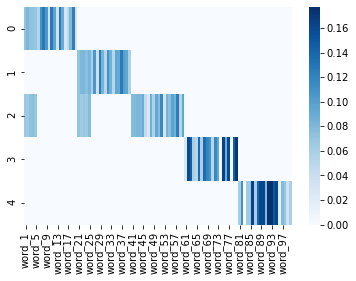

In [3]:
main_topic_signal = 10
topic_weights = [2,2, 1, 3, 4]  # Adjust weights as desired

# RCT
gamma1 = gamma2 = 0 

psi1= 10
psi2= 5
beta0 = 0
beta1 = 0
beta2 = 0
beta3 = -30
beta4 = 0
beta5 = 0
rho1 = 0 #Interaction effect between words in topic 3 and topic 4: X2_41*X2_42*X2_61* X2_62 
rho2 = 0 #Interaction effect between words in topic 1 and 2
rho3 = 0 #TBD

n, m1, m2, R = 2000, 10, 100, 5

eta= 1 #controls noise level 
epsilon= 0.2 #controls noise level 

v_signal_val = 5  #words 1, 2, 21, 22's values in V matrix.

seed_train=0
correlation_type= 6
################################################################## Train
NA, Vtrue_train, NA, rmse_min_train = generate_data_dlearning(seed=seed_train, n=n, r=R, m1=m1, m2=m2, zeta1=1, zeta2=2,
                                main_topic_signal=main_topic_signal, topic_weights=topic_weights, eta=eta, epsilon=epsilon, gamma1=gamma1, gamma2=gamma2,
                                beta0=beta0, psi1=psi1, psi2=psi2, beta1=beta1, beta2=beta2, beta3=beta3, beta4=beta4, beta5=beta5, rho1=rho1, rho2=rho2, rho3=rho3, v_signal_val=v_signal_val, scenario="A",sparse=True, correlation_type=correlation_type)

sns.heatmap(Vtrue_train, cmap='Blues')

Vtrue_train

In [4]:
# Adjust the figure folder path to a location where permissions are not an issue
fig_folder = '/ix1/ltang/ziz60/nmf_causal_eval/26_dlearning/output18_scenario2/'  # Local directory where we should have permission

# Ensure the fig_folder directory exists
os.makedirs(fig_folder, exist_ok=True)

# Update PDF paths with the new directory
hist_pdf_path = f'{fig_folder}fig/all_hist_plots.pdf'
one_sd_pdf_path = f'{fig_folder}fig/all_one_sd_plots.pdf'

# Initialize PDF files for plots
hist_pdf = PdfPages(hist_pdf_path)
one_sd_pdf = PdfPages(one_sd_pdf_path)

# Initialize empty lists to store the reports from each iteration
all_test_results = []
all_train_results = []
all_validation_results = []
output_ls = [None]* 120

# Function to evaluate and generate plots


base_path_1 = '/ix1/ltang/ziz60/nmf_causal_eval/26_dlearning/output18_scenario2/'

scenario = 'scenario2_sim'
joblib_extension = '.joblib'

# Loop to run the eval_function with different values of i
for i in range(100): #TODO: Change the number of simulations to load
    try:
        eval_function(i, base_path_1, hist_pdf, one_sd_pdf, benchmark=True)
    except FileNotFoundError as e:
        print(f"File not found for i={i}: {e}. Skipping to the next.")
        continue
# Close the PDF files
hist_pdf.close()
one_sd_pdf.close()

print(f"All hist plots saved to {hist_pdf_path}")
print(f"All one_sd plots saved to {one_sd_pdf_path}")


####################################
#alpha_grid = all_train_results[0]['alpha1'].unique()
lambda_grid = all_train_results[0]['lambda'].unique()

#print(alpha_grid)
print(lambda_grid)

####################################
benchmark_train_results = pd.concat(all_train_results, ignore_index=True)
benchmark_validation_results = pd.concat(all_validation_results, ignore_index=True)
benchmark_test_results = pd.concat(all_test_results, ignore_index=True)

# number of simulations 
num_sim = len(benchmark_test_results['simulation'].unique())
print("number of simulations:",num_sim)




Loading: /ix1/ltang/ziz60/nmf_causal_eval/26_dlearning/output18_scenario2/scenario2_sim_0_100_1000.joblib
Lambda values: [0.e+00 1.e-10 1.e-05 1.e-03 1.e+00 1.e+01 1.e+02]
Loading: /ix1/ltang/ziz60/nmf_causal_eval/26_dlearning/output18_scenario2/scenario2_sim_1_101_1001.joblib
Lambda values: [0.e+00 1.e-10 1.e-05 1.e-03 1.e+00 1.e+01 1.e+02]
Loading: /ix1/ltang/ziz60/nmf_causal_eval/26_dlearning/output18_scenario2/scenario2_sim_2_102_1002.joblib
Lambda values: [0.e+00 1.e-10 1.e-05 1.e-03 1.e+00 1.e+01 1.e+02]
Loading: /ix1/ltang/ziz60/nmf_causal_eval/26_dlearning/output18_scenario2/scenario2_sim_3_103_1003.joblib
Lambda values: [0.e+00 1.e-10 1.e-05 1.e-03 1.e+00 1.e+01 1.e+02]
Loading: /ix1/ltang/ziz60/nmf_causal_eval/26_dlearning/output18_scenario2/scenario2_sim_4_104_1004.joblib
Lambda values: [0.e+00 1.e-10 1.e-05 1.e-03 1.e+00 1.e+01 1.e+02]
Loading: /ix1/ltang/ziz60/nmf_causal_eval/26_dlearning/output18_scenario2/scenario2_sim_5_105_1005.joblib
Lambda values: [0.e+00 1.e-10 1.e-

In [5]:


#################################################### 
#########  OPTIMAL Results ######################### 
####################################################
criteria = "largest" ####### change this!!!!
benchmark_validation_results_optimal = benchmark_validation_results[benchmark_validation_results['within_1sd_TF'] == True]

# largest lambda
if criteria == "largest":
    benchmark_validation_results_optimal = benchmark_validation_results_optimal.groupby('simulation').apply(
        lambda x: x.sort_values(by=['lambda'], ascending=False).head(1)
    ).reset_index(drop=True)

elif criteria == "smallest":
    benchmark_validation_results_optimal = benchmark_validation_results_optimal.groupby('simulation').apply(
        lambda x: x.sort_values(by=['lambda'], ascending=True).head(1)
    ).reset_index(drop=True)

simulation_ls = benchmark_validation_results_optimal["simulation"]

  
simulation_ls = benchmark_validation_results_optimal["simulation"]
output_optimal_ls = [None]*num_sim
b2_optimal_ls = []


benchmark_test_results_optimal = []

for i, sim in enumerate(simulation_ls):
    #print("Simulation # ",sim)
    output_i = output_ls[sim]
    
    benchmark_validation_results_optimal_i = benchmark_validation_results_optimal[benchmark_validation_results_optimal['simulation']==sim]
    benchmark_test_results_optimal_i = benchmark_test_results[benchmark_test_results['simulation'] == sim]

    lambda_optimal = benchmark_validation_results_optimal_i[['lambda']].iloc[0,0]
    lambda_index = np.where(lambda_grid == lambda_optimal)[0][0]
    #print("lambda_optimal=", lambda_optimal, ". Index:",lambda_index )

    #print('type of lambda_index:', type(lambda_index))
    optimal_output_i = output_i[lambda_index]
    output_optimal_ls[sim] = optimal_output_i
    benchmark_test_results_optimal_i = benchmark_test_results_optimal_i[
        benchmark_test_results_optimal_i['lambda'] == lambda_optimal
    ]
    benchmark_test_results_optimal_i['simulation'] = sim
    benchmark_test_results_optimal.append(benchmark_test_results_optimal_i)
    
    b2_out_i = optimal_output_i[2]
    b2_optimal_ls.append(b2_out_i)
    
benchmark_test_results_optimal = pd.concat(benchmark_test_results_optimal, ignore_index=True)

# get the average beta hat, used for colorbar
b2_optimal_ls= np.array(b2_optimal_ls)
b2_optimal = b2_optimal_ls.reshape(len(b2_optimal_ls), len(b2_optimal_ls[0])) # reshape b2_optimal_ls
b2_optimal = pd.DataFrame(b2_optimal)
b2_optimal = b2_optimal.iloc[:, m1+1:]
b2_avg = b2_optimal.abs().mean(axis=0).values


#################################################### 
######### benchmark Eval Criteria ####################### 
####################################################
# Calculate the mean
mean_value = benchmark_test_results_optimal['rmse'].mean()
std_dev = benchmark_test_results_optimal['rmse'].std()

print(f"RMSE Mean: {mean_value}")
print(f"RMSE Standard Deviation: {std_dev}")

# Calculate the mean
mean_value = benchmark_test_results_optimal['classification_error'].mean()
std_dev = benchmark_test_results_optimal['classification_error'].std()

print(f"CE Mean: {mean_value}")
print(f"CE Standard Deviation: {std_dev}")


benchmark_test_results = benchmark_test_results_optimal[['rmse', 'accuracy_dx','specificity','sensitivity', 'classification_error']]
benchmark_test_results['method'] = "benchmark"
                         
benchmark_test_results['v_minus_vhat_norm'] = np.nan
benchmark_test_results['x2_minus_uv_norm'] = np.nan

benchmark_test_results

RMSE Mean: 12.692493627777385
RMSE Standard Deviation: 0.1611850897270259
CE Mean: 0.10606666666666668
CE Standard Deviation: 0.006385541577888123


<ipython-input-5-21a64cbe2870>:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  benchmark_test_results['method'] = "benchmark"
<ipython-input-5-21a64cbe2870>:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  benchmark_test_results['v_minus_vhat_norm'] = np.nan


,rmse,accuracy_dx,specificity,sensitivity,classification_error,method,v_minus_vhat_norm,x2_minus_uv_norm
0,12.906472,0.8980,0.942169,0.825166,0.1020,benchmark,NaN,NaN
1,12.670155,0.8865,0.932998,0.817618,0.1135,benchmark,NaN,NaN
2,12.811384,0.8930,0.923786,0.847395,0.1070,benchmark,NaN,NaN
3,12.774987,0.8850,0.928808,0.818182,0.1150,benchmark,NaN,NaN
4,12.481775,0.8850,0.919768,0.831858,0.1150,benchmark,NaN,NaN
5,12.665634,0.8930,0.936118,0.825417,0.1070,benchmark,NaN,NaN
6,12.552360,0.9040,0.950204,0.830968,0.0960,benchmark,NaN,NaN
7,12.840599,0.8900,0.940986,0.807339,0.1100,benchmark,NaN,NaN
8,12.683156,0.8835,0.924545,0.827627,0.1165,benchmark,NaN,NaN
9,12.810261,0.8965,0.934233,0.841523,0.1035,benchmark,NaN,NaN


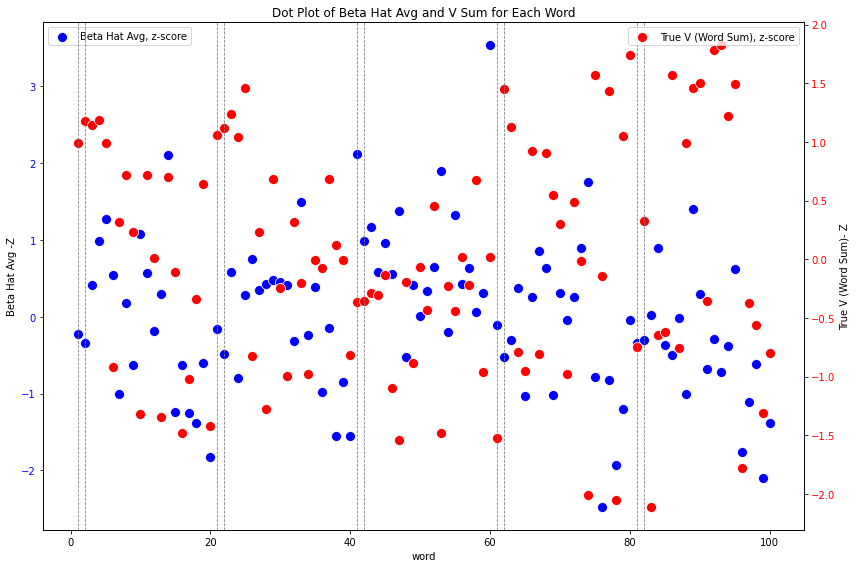

In [6]:
true_word_sum = Vtrue_train.sum(axis=0).values

b2_benchmark_df = pd.DataFrame(b2_avg, columns = ['beta_hat_avg'])
b2_benchmark_df['word'] = range(len(b2_avg))
b2_benchmark_df['word'] = b2_benchmark_df['word']+1
b2_benchmark_df['v_sum'] = true_word_sum

################################################################################################
# Set the plot size
plt.figure(figsize=(12, 8))

# Create the first axis for 'beta_hat_avg'
ax1 = plt.gca()  # Get current axis

mean_beta_hat_avg = b2_benchmark_df['beta_hat_avg'].mean()
std_beta_hat_avg = b2_benchmark_df['beta_hat_avg'].std()

# Calculate the z-score
b2_benchmark_df['beta_hat_avg_z'] = (b2_benchmark_df['beta_hat_avg'] - mean_beta_hat_avg) / std_beta_hat_avg



mean_v_sum = b2_benchmark_df['v_sum'].mean()
std_v_sum = b2_benchmark_df['v_sum'].std()

# Calculate the z-score
b2_benchmark_df['v_sum_z'] = (b2_benchmark_df['v_sum'] - mean_v_sum) / std_v_sum


sns.scatterplot(x='word', y='beta_hat_avg_z', data=b2_benchmark_df, ax=ax1, color='blue', label='Beta Hat Avg, z-score', s=100)
ax1.set_ylabel('Beta Hat Avg -Z')
ax1.set_title('Dot Plot of Beta Hat Avg and V Sum for Each Word')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for 'v_sum'
ax2 = ax1.twinx()  # Create a new axes sharing the same x-axis
sns.scatterplot(x='word', y='v_sum_z', data=b2_benchmark_df, ax=ax2, color='red', label='True V (Word Sum), z-score', s=100)
ax2.set_ylabel('True V (Word Sum)- Z')
ax2.tick_params(axis='y', labelcolor='red')

# Optional: Adjust the limits of both axes for better visualization
#ax1.set_ylim(b2_benchmark_df['beta_hat_avg'].min() - 1, b2_benchmark_df['beta_hat_avg'].max() + 1)  # Adjust y-limits for beta_hat_avg
#ax2.set_ylim(b2_benchmark_df['v_sum_z'].min() - 1, b2_benchmark_df['v_sum_z'].max() + 1)  # Adjust y-limits for v_sum

# Show the legend
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Add vertical lines at specified x-values
for x in [1, 2, 21, 22, 41, 42, 61, 62, 81, 82]:
    plt.axvline(x=x, color='gray', linestyle='--', linewidth=0.8)

    
# Rotate x-axis labels for better visibility
plt.xticks(rotation=90)

# Display the plot
plt.tight_layout()
plt.show()

# Scenario 2: Interaction -- SNMF

In [7]:
# Adjust the figure folder path to a location where permissions are not an issue
fig_folder = '/ix1/ltang/ziz60/nmf_causal_eval/21_simple_scenario_interaction/output18/'  # Local directory where we should have permission

# Ensure the fig_folder directory exists
os.makedirs(fig_folder, exist_ok=True)

# Update PDF paths with the new directory
hist_pdf_path = f'{fig_folder}fig/all_hist_plots.pdf'
one_sd_pdf_path = f'{fig_folder}fig/all_one_sd_plots.pdf'

# Initialize PDF files for plots
hist_pdf = PdfPages(hist_pdf_path)
one_sd_pdf = PdfPages(one_sd_pdf_path)

# Initialize empty lists to store the reports from each iteration
all_test_results = []
all_train_results = []
all_validation_results = []
output_ls = [None]* 120
U_validation_sim_ls  = [None]* 120
U_test_ls =  [None]* 120
# Function to evaluate and generate plots


base_path_1 = '/ix1/ltang/ziz60/nmf_causal_eval/21_simple_scenario_interaction/output18/'

scenario = 'scenario2_r5_sim'
joblib_extension = '.joblib'

# Loop to run the eval_function with different values of i
for i in range(100): #TODO: Change the number of simulations to load
    try:
        eval_function(i, base_path_1, hist_pdf, one_sd_pdf, benchmark = False)
    except FileNotFoundError as e:
        print(f"File not found for i={i}: {e}. Skipping to the next.")
        continue
# Close the PDF files
hist_pdf.close()
one_sd_pdf.close()

print(f"All hist plots saved to {hist_pdf_path}")
print(f"All one_sd plots saved to {one_sd_pdf_path}")


####################################
alpha_grid = all_train_results[0]['alpha1'].unique()
lambda_grid = all_train_results[0]['lambda'].unique()

print(alpha_grid)
print(lambda_grid)

####################################
snmf_train_results = pd.concat(all_train_results, ignore_index=True)
snmf_validation_results = pd.concat(all_validation_results, ignore_index=True)
snmf_test_results = pd.concat(all_test_results, ignore_index=True)

# number of simulations 
num_sim = len(snmf_test_results['simulation'].unique())
print("number of simulations:",num_sim)




Loading: /ix1/ltang/ziz60/nmf_causal_eval/21_simple_scenario_interaction/output18/scenario2_r5_sim_0_100_1000.joblib
Alpha values: [1.e-07 1.e-03 1.e-01 1.e+00]
Lambda values: [1.e-10 1.e-05]
Loading: /ix1/ltang/ziz60/nmf_causal_eval/21_simple_scenario_interaction/output18/scenario2_r5_sim_1_101_1001.joblib
Alpha values: [1.e-07 1.e-03 1.e-01 1.e+00]
Lambda values: [1.e-10 1.e-05]
Loading: /ix1/ltang/ziz60/nmf_causal_eval/21_simple_scenario_interaction/output18/scenario2_r5_sim_2_102_1002.joblib
Alpha values: [1.e-07 1.e-03 1.e-01 1.e+00]
Lambda values: [1.e-10 1.e-05]
Loading: /ix1/ltang/ziz60/nmf_causal_eval/21_simple_scenario_interaction/output18/scenario2_r5_sim_3_103_1003.joblib
Alpha values: [1.e-07 1.e-03 1.e-01 1.e+00]
Lambda values: [1.e-10 1.e-05]
Loading: /ix1/ltang/ziz60/nmf_causal_eval/21_simple_scenario_interaction/output18/scenario2_r5_sim_4_104_1004.joblib
Alpha values: [1.e-07 1.e-03 1.e-01 1.e+00]
Lambda values: [1.e-10 1.e-05]
Loading: /ix1/ltang/ziz60/nmf_causal_eva

In [8]:
#################################################### 
#########  OPTIMAL Results ######################### 
####################################################
criteria = "largest" ####### change this!!!!
snmf_validation_results_optimal = snmf_validation_results[snmf_validation_results['within_1sd_TF'] == True]

# largest alpha and lambda
if criteria == "largest":
    snmf_validation_results_optimal = snmf_validation_results_optimal.groupby('simulation').apply(
        lambda x: x.sort_values(by=['lambda', 'alpha1'], ascending=False).head(1)
    ).reset_index(drop=True)

elif criteria == "smallest":
    snmf_validation_results_optimal = snmf_validation_results_optimal.groupby('simulation').apply(
        lambda x: x.sort_values(by=['lambda', 'alpha1'], ascending=True).head(1)
    ).reset_index(drop=True)

simulation_ls = snmf_validation_results_optimal["simulation"]

  
simulation_ls = snmf_validation_results_optimal["simulation"]
output_optimal_ls = [None]*200
U_train_optimal_ls = [None]*200
U_test_optimal_ls = [None]*200
U_validation_i_optimal_ls= [None]*200
V_optimal_ls = []
b2_optimal_ls = []


snmf_test_results_optimal = []

for i, sim in enumerate(simulation_ls):
    #print("Simulation # ",sim)
    output_i = output_ls[sim]
    
    snmf_validation_results_optimal_i = snmf_validation_results_optimal[snmf_validation_results_optimal['simulation']==sim]
    snmf_test_results_optimal_i = snmf_test_results[snmf_test_results['simulation'] == sim]
    
    U_test_i = U_test_ls[sim] # !!!TODO: change this for output 5
    U_validation_i = U_validation_sim_ls[sim] # !!!TODO: change this for output 5
        
    alpha_optimal = snmf_validation_results_optimal_i[['alpha1']].iloc[0,0]
    alpha_index = np.where(alpha_grid == alpha_optimal)[0][0]

    #print("alpha_optimal=", alpha_optimal, ". Index:",alpha_index )

    lambda_optimal = snmf_validation_results_optimal_i[['lambda']].iloc[0,0]
    lambda_index = np.where(lambda_grid == lambda_optimal)[0][0]
    #print("lambda_optimal=", lambda_optimal, ". Index:",lambda_index )

    optimal_output_i = output_i[alpha_index][lambda_index]
    output_optimal_ls[sim] = optimal_output_i
    snmf_test_results_optimal_i = snmf_test_results_optimal_i[
        (snmf_test_results_optimal_i['alpha'] == alpha_optimal) & 
        (snmf_test_results_optimal_i['lambda'] == lambda_optimal)
    ]
    snmf_test_results_optimal_i['simulation'] = sim
    snmf_test_results_optimal.append(snmf_test_results_optimal_i)
    
    U_train_optimal_i = optimal_output_i[2]
    U_train_optimal_ls[sim] = U_train_optimal_i
    U_validation_i_optimal_ls[sim] = U_validation_i[alpha_index][lambda_index] # !!!TODO: change this for output 5
    U_test_opt = U_test_i[alpha_index][lambda_index]# !!!TODO: change this for output 5
    U_test_optimal_ls[sim] = U_test_opt# !!!TODO: change this for output 5
    
    V_optimal_i = optimal_output_i[3]
    V_2stage_r = reorder_V(Vtrue_train, V_optimal_i, m2, True)
    V_2stage_R = reorder_V(Vtrue_train, V_optimal_i, m2, False)
    V_optimal_ls.append(V_2stage_R)

    b2_out_i = optimal_output_i[4]
    b2_out_i_r = reorder_beta(Vtrue_train, V_optimal_i, b2_out_i, m1, m2, True)
    b2_out_i_R = reorder_beta(Vtrue_train, V_optimal_i, b2_out_i, m1, m2, False)
    b2_optimal_ls.append(b2_out_i_R)


In [9]:
snmf_validation_results_optimal['lambda_alpha'].value_counts()

lambda1e-05_alpha1.0      34
lambda1e-10_alpha1e-07    17
lambda1e-05_alpha1e-07     9
Name: lambda_alpha, dtype: int64

In [10]:
snmf_test_results_optimal = pd.concat(snmf_test_results_optimal, ignore_index=True)

# get the average beta hat, used for colorbar
b2_optimal_ls= np.array(b2_optimal_ls)
b2_optimal = b2_optimal_ls.reshape(len(b2_optimal_ls), len(b2_optimal_ls[0])) # reshape b2_optimal_ls
b2_optimal = pd.DataFrame(b2_optimal)
b2_optimal = b2_optimal.iloc[:, m1+1:]
b2_avg = b2_optimal.abs().mean(axis=0).values


#################################################### 
######### SNMF Eval Criteria ####################### 
####################################################
# Calculate the mean
mean_value = snmf_test_results_optimal['rmse'].mean()
std_dev = snmf_test_results_optimal['rmse'].std()

print(f"RMSE Mean: {mean_value}")
print(f"RMSE Standard Deviation: {std_dev}")

# Calculate the mean
mean_value = snmf_test_results_optimal['classification_error'].mean()
std_dev = snmf_test_results_optimal['classification_error'].std()

print(f"CE Mean: {mean_value}")
print(f"CE Standard Deviation: {std_dev}")

# Calculate the mean
mean_value = snmf_test_results_optimal['v_minus_vhat_norm'].mean()
std_dev = snmf_test_results_optimal['v_minus_vhat_norm'].std()

print(f"V ERROR: Mean: {mean_value}")
print(f"V ERROR: Standard Deviation: {std_dev}")

# Calculate the mean
mean_value = snmf_test_results_optimal['x2_minus_uv_norm'].mean()
std_dev = snmf_test_results_optimal['x2_minus_uv_norm'].std()

print(f"X2 ERROR: Mean: {mean_value}")
print(f"X2 ERROR: Standard Deviation: {std_dev}")



snmf_test_results = snmf_test_results_optimal[['rmse', 'accuracy_dx','specificity','sensitivity', 'classification_error','v_minus_vhat_norm','x2_minus_uv_norm']]
snmf_test_results['method'] = "snmf"

RMSE Mean: 12.49237910292973
RMSE Standard Deviation: 0.19856189389797463
CE Mean: 0.09590833333333332
CE Standard Deviation: 0.007142906678601449
V ERROR: Mean: 0.011607408186929572
V ERROR: Standard Deviation: 0.006328044047196776
X2 ERROR: Mean: 0.001642786470575454
X2 ERROR: Standard Deviation: 8.668783477951172e-05


<ipython-input-10-2078e5711587>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  snmf_test_results['method'] = "snmf"


In [11]:
snmf_test_results

,rmse,accuracy_dx,specificity,sensitivity,classification_error,v_minus_vhat_norm,x2_minus_uv_norm,method
0,12.574744,0.9100,0.939739,0.862694,0.0900,0.004743,0.001740,snmf
1,12.602489,0.9105,0.934319,0.873402,0.0895,0.003243,0.001731,snmf
2,12.799879,0.9070,0.943730,0.846561,0.0930,0.018080,0.001605,snmf
3,12.513407,0.8995,0.941225,0.835859,0.1005,0.010302,0.001675,snmf
4,12.758968,0.9055,0.943475,0.848181,0.0945,0.005369,0.001705,snmf
5,12.385502,0.8920,0.936637,0.820546,0.1080,0.007609,0.001655,snmf
6,12.442199,0.8995,0.944398,0.831447,0.1005,0.018418,0.001427,snmf
7,12.623390,0.8930,0.929196,0.831763,0.1070,0.003925,0.001719,snmf
8,12.616141,0.9085,0.932343,0.871827,0.0915,0.007089,0.001696,snmf
9,12.718857,0.9095,0.926483,0.884184,0.0905,0.005456,0.001730,snmf


# Scenario 2: Interaction --  Two-Stage NMF

In [12]:
vsignal = v_signal_val



# Initialize lists to store results from each simulation
results = []
V_2s_list = []
b2_2s_list = []
# Run 10 simulations with different seeds
for i in range(num_sim):
    seed_train = i
    seed_test = 1000 + i

    # Generate training and testing data
    data_train, Vtrue_train, NA, rmse_min_train = generate_data_dlearning(seed=seed_train, n=n, r=R, m1=m1, m2=m2, zeta1=1, zeta2=2,
                                    main_topic_signal=main_topic_signal, topic_weights=topic_weights, eta=eta, epsilon=epsilon, gamma1=gamma1, gamma2=gamma2,
                                    beta0=beta0, psi1=psi1, psi2=psi2, beta1=beta1, beta2=beta2, beta3=beta3, beta4=beta4, beta5=beta5, rho1=rho1, rho2=rho2, rho3=rho3, v_signal_val=v_signal_val, scenario="A", sparse=True, correlation_type=correlation_type)
    
    data_test, Vtrue_test, NA, rmse_min_test = generate_data_dlearning(seed=seed_test, n=n, r=R, m1=m1, m2=m2, zeta1=1, zeta2=2,
                                    main_topic_signal=main_topic_signal, topic_weights=topic_weights, eta=eta, epsilon=epsilon, gamma1=gamma1, gamma2=gamma2,
                                    beta0=beta0, psi1=psi1, psi2=psi2, beta1=beta1, beta2=beta2, beta3=beta3, beta4=beta4, beta5=beta5, rho1=rho1, rho2=rho2, rho3=rho3, v_signal_val=v_signal_val, scenario="A", sparse=True, correlation_type=correlation_type)
   
    
    # Run the 2-stage NMF model
    accuracy_train, rmse_train,  specificity_test, sensitivity_test, accuracy_test, rmse_test, classification_error_test,v_minus_vhat_norm, V_2stage_r, beta_2stage_r,  beta_2stage_R, x2_minus_uv_norm = run_2s_nmf(data_train, data_test, Vtrue_train, m1, m2, R, 5)
    V_2s_list.append(V_2stage_r)
    b2_2s_list.append(beta_2stage_R)
    
    # Store results in a dictionary
    results.append({
        'seed_train': seed_train,
        'seed_test': seed_test,
        'specificity': specificity_test,
        'sensitivity': sensitivity_test,
        'accuracy_dx': accuracy_test,
        'rmse': rmse_test,
        'classification_error':classification_error_test,
        'v_minus_vhat_norm' : v_minus_vhat_norm,
        'x2_minus_uv_norm' : x2_minus_uv_norm
        # Add other results if needed
    })

# Concatenate all results into a single DataFrame
results_df = pd.DataFrame(results)


twostage_test_results = results_df[['rmse', 'accuracy_dx','specificity','sensitivity', 'classification_error', 'v_minus_vhat_norm','x2_minus_uv_norm']]
twostage_test_results['method'] = "two_stage"


# get the average beta hat, used for colorbar
b2_2s_list= np.array(b2_2s_list)
b2_2s = b2_2s_list.reshape(len(b2_2s_list), len(b2_2s_list[0])) # reshape b2_optimal_ls
b2_2s = pd.DataFrame(b2_2s)
b2_2s = b2_2s.iloc[:, m1+1:]
b2_2s_avg = b2_2s.abs().mean(axis=0).values



###############################################################
###############################################################
# Calculate the mean
mean_value = twostage_test_results['rmse'].mean()
std_dev = twostage_test_results['rmse'].std()

print(f"RMSE Mean: {mean_value}")
print(f"RMSE Standard Deviation: {std_dev}")

# Calculate the mean
mean_value = twostage_test_results['classification_error'].mean()
std_dev = twostage_test_results['classification_error'].std()

print(f"CE Mean: {mean_value}")
print(f"CE Standard Deviation: {std_dev}")

# Calculate the mean
mean_value = twostage_test_results['v_minus_vhat_norm'].mean()
std_dev = twostage_test_results['v_minus_vhat_norm'].std()

print(f"V ERROR: Mean: {mean_value}")
print(f"V ERROR: Standard Deviation: {std_dev}")

# Calculate the mean
mean_value = twostage_test_results['x2_minus_uv_norm'].mean()
std_dev = twostage_test_results['x2_minus_uv_norm'].std()

print(f"X2 ERROR: Mean: {mean_value}")
print(f"X2 ERROR: Standard Deviation: {std_dev}")

!!!At iteration 0 Absolute difference in current objective and previous objective / initial objective= 0.0 , END!!!
!!!At iteration 0 Absolute difference in current objective and previous objective / initial objective= 0.0 , END!!!
!!!At iteration 0 Absolute difference in current objective and previous objective / initial objective= 0.0 , END!!!
!!!At iteration 0 Absolute difference in current objective and previous objective / initial objective= 0.0 , END!!!
!!!At iteration 0 Absolute difference in current objective and previous objective / initial objective= 0.0 , END!!!
!!!At iteration 0 Absolute difference in current objective and previous objective / initial objective= 0.0 , END!!!
!!!At iteration 0 Absolute difference in current objective and previous objective / initial objective= 0.0 , END!!!
!!!At iteration 0 Absolute difference in current objective and previous objective / initial objective= 0.0 , END!!!
!!!At iteration 0 Absolute difference in current objective and previous 

<ipython-input-12-d3e85ddb8ff7>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  twostage_test_results['method'] = "two_stage"


In [13]:
#################################################### 
##### Combine NMF AND SNMF Results################## 
####################################################

combined_results = pd.concat([snmf_test_results, twostage_test_results,benchmark_test_results], axis=0, ignore_index=True)

V_snmf_list =V_optimal_ls

combined_results

,rmse,accuracy_dx,specificity,sensitivity,classification_error,v_minus_vhat_norm,x2_minus_uv_norm,method
0,12.574744,0.9100,0.939739,0.862694,0.0900,0.004743,0.001740,snmf
1,12.602489,0.9105,0.934319,0.873402,0.0895,0.003243,0.001731,snmf
2,12.799879,0.9070,0.943730,0.846561,0.0930,0.018080,0.001605,snmf
3,12.513407,0.8995,0.941225,0.835859,0.1005,0.010302,0.001675,snmf
4,12.758968,0.9055,0.943475,0.848181,0.0945,0.005369,0.001705,snmf
...,...,...,...,...,...,...,...,...
175,12.759799,0.8980,0.941723,0.834559,0.1020,NaN,NaN,benchmark
176,12.508418,0.9020,0.939145,0.844388,0.0980,NaN,NaN,benchmark
177,12.868812,0.9040,0.952303,0.829082,0.0960,NaN,NaN,benchmark
178,12.856803,0.8910,0.935457,0.825279,0.1090,NaN,NaN,benchmark


In [14]:


##########################################################
##########################################################
# SNMF
# Step 1: Normalize each V in V_snmf_list by its column norm
V_snmf_normalized_list = []

for V in V_snmf_list:
    # Calculate the norm of each column
    column_norms =np.linalg.norm(V, axis=1, keepdims=True)
    # Normalize each column of V
    V_normalized = V / column_norms
    # Add the normalized V to the list
    V_snmf_normalized_list.append(V_normalized)
    
# Step 2: Calculate the element-wise average of all normalized V matrices
if len(V_snmf_normalized_list) > 0:
    # Initialize V_avg with zeros of the same shape as the first normalized matrix
    V_avg = np.zeros_like(V_snmf_normalized_list[0])

    # Sum up all normalized matrices element-wise
    for V_normalized in V_snmf_normalized_list:
        V_avg += V_normalized

    # Divide by the number of matrices to get the average
    V_avg /= len(V_snmf_normalized_list)

    print("V_avg constructed successfully.")
else:
    print("V_snmf_normalized_list is empty. Cannot construct V_avg.")
    
V_snmf_avg = V_avg
##########################################################
##########################################################
# TWO - STAGE
#Step 1: Normalize each V in V_snmf_list by its column norm
V_2s_normalized_list = []

for V in V_2s_list:
    # Calculate the norm of each column
    column_norms =np.linalg.norm(V, axis=1, keepdims=True)    
    # Normalize each column of V
    V_normalized = V / column_norms
    
    # Add the normalized V to the list
    V_2s_normalized_list.append(V_normalized)
    
    
V_2s_normalized_list  = V_2s_list
# Step 2: Calculate the element-wise average of all normalized V matrices
if len(V_2s_normalized_list) > 0:
    # Initialize V_avg with zeros of the same shape as the first normalized matrix
    V_avg = np.zeros_like(V_2s_normalized_list[0])

    # Sum up all normalized matrices element-wise
    for V_normalized in V_2s_normalized_list:
        V_avg += V_normalized

    # Divide by the number of matrices to get the average
    V_avg /= len(V_2s_normalized_list)

    print("V_avg constructed successfully.")
else:
    print("V_snmf_normalized_list is empty. Cannot construct V_avg.")
    
V_2s_avg = V_avg


##################################################################
##################################################################
##################################################################
# V plot -- top words
# takes three V matrics: 1. Vtrue_train, 2.V_2stage_r, 3.V_snmf_r
Vtrue_df = Vtrue_train.T
Vtrue_df.reset_index(inplace=True)
# Rename the column 'index' to whatever you prefer, e.g., 'row_name'
Vtrue_df.rename(columns={'index': 'word'}, inplace=True)
# Create a dictionary with the new column names
new_column_names = {
    0: 'T1',
    1: 'T2',
    2: 'T3',
    3: 'T4',
    4: 'T5',
   
}
# Rename all columns
Vtrue_df.rename(columns=new_column_names, inplace=True)
###################################################################
#norms = np.linalg.norm(V_2stage_r, axis=1, keepdims=True)
#V_2stage_r_norm = V_2stage_r/ norms
V_2s_df = pd.DataFrame(V_2s_avg.T)
    
num_rows = len(V_2s_df)
V_2s_df[['word']] = ['word_' + str(i+1) for i in range(num_rows)]

# Create a dictionary with the new column names
new_column_names = {
    0: 'T1',
    1: 'T2',
    2: 'T3',
    3: 'T4',
    4: 'T5',
}

# Rename all columns
V_2s_df.rename(columns=new_column_names, inplace=True)
###################################################################
#norms = np.linalg.norm(V_snmf_r, axis=1, keepdims=True)
#V_snmf_r_norm = V_snmf_r/ norms
V_snmf_df = pd.DataFrame(V_snmf_avg.T)
num_rows = len(V_snmf_df)
V_snmf_df[['word']] = ['word_' + str(i+1) for i in range(num_rows)]
new_column_names = {
    0: 'T1',
    1: 'T2',
    2: 'T3',
    3: 'T4',
    4: 'T5',
}

# Rename all columns
V_snmf_df.rename(columns=new_column_names, inplace=True)

# Set 'word' column as the index to use it as row labels
V_2s_df.set_index('word', inplace=True)
V_snmf_df.set_index('word', inplace=True)
Vtrue_df.set_index('word', inplace=True)

#################### Make copies for Scenario 2
Vtrue_df_scen2 = Vtrue_df.copy()
V_snmf_df_scen2 = V_snmf_df.copy()
V_2s_df_scen2 = V_2s_df.copy()

b2_avg_scen2 = b2_avg.copy()
b2_2s_avg_scen2 = b2_2s_avg.copy()

combined_results_scen2 = combined_results.copy()

V_avg constructed successfully.
V_avg constructed successfully.


---------------------------------------

# Scenario 1 --  Benchmark

,word_1,word_2,word_3,word_4,word_5,word_6,word_7,word_8,word_9,word_10,...,word_111,word_112,word_113,word_114,word_115,word_116,word_117,word_118,word_119,word_120
0,0.077328,0.137655,0.109099,0.066904,0.150215,0.011581,0.07962,0.02029,0.016084,0.030619,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,...,0.139035,0.142092,0.105337,0.108216,0.06573,0.03624,0.101361,0.060023,0.101212,0.066181


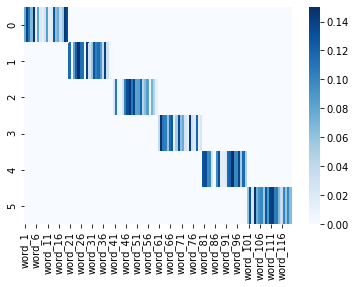

In [15]:
vsignal = 5


main_topic_signal = 10
topic_weights = [1,1,1,1.5, 1.5, 1.5]  # Adjust weights as desired

# RCT
gamma1 = gamma2 = 0 

psi1= 10
psi2= 5
beta0 = 0
beta1 = -15 # topic 1
beta2 = 20 # topic 2
beta3 = -30 # topic 3
beta4 = 0 # topic 4
beta5 = 0 # topic 5
rho1 = 0 #Interaction effect between words in topic 3 and topic 4: X2_41*X2_42*X2_61* X2_62 
rho2 = 0 #Interaction effect between words in topic 1 and 2
rho3 = 0 #TBD

n, m1, m2, R = 2000, 10, 120, 6

eta= 0.7 #controls noise level 
epsilon = 0.1 #controls noise level 

v_signal_val = vsignal

################################################################## Train

NA, Vtrue_train, NA, rmse_min_train = generate_data_dlearning(seed=0, n=n, r=R, m1=m1, m2=m2, zeta1=1, zeta2=2,
                                    main_topic_signal=main_topic_signal, topic_weights=topic_weights, eta=eta, epsilon=epsilon, gamma1=gamma1, gamma2=gamma2,
                                    beta0=beta0, psi1=psi1, psi2=psi2, beta1=beta1, beta2=beta2, beta3=beta3, beta4=beta4, beta5=beta5, rho1=rho1, rho2=rho2, rho3=rho3, v_signal_val=v_signal_val, scenario="D", sparse=True, correlation_type=correlation_type)
    
sns.heatmap(Vtrue_train, cmap='Blues')
Vtrue_train

In [16]:
# Adjust the figure folder path to a location where permissions are not an issue
fig_folder = '/ix1/ltang/ziz60/nmf_causal_eval/26_dlearning/output24_scenario1/'  # Local directory where we should have permission

# Ensure the fig_folder directory exists
os.makedirs(fig_folder, exist_ok=True)

# Update PDF paths with the new directory
hist_pdf_path = f'{fig_folder}fig/all_hist_plots.pdf'
one_sd_pdf_path = f'{fig_folder}fig/all_one_sd_plots.pdf'

# Initialize PDF files for plots
hist_pdf = PdfPages(hist_pdf_path)
one_sd_pdf = PdfPages(one_sd_pdf_path)

# Initialize empty lists to store the reports from each iteration
all_test_results = []
all_train_results = []
all_validation_results = []
output_ls = [None]* 120

# Function to evaluate and generate plots


base_path_1 = '/ix1/ltang/ziz60/nmf_causal_eval/26_dlearning/output24_scenario1/'

scenario = 'scenario1_sim'
joblib_extension = '.joblib'

# Loop to run the eval_function with different values of i
for i in range(100): #TODO: Change the number of simulations to load
    try:
        eval_function(i, base_path_1, hist_pdf, one_sd_pdf, benchmark=True)
    except FileNotFoundError as e:
        print(f"File not found for i={i}: {e}. Skipping to the next.")
        continue
# Close the PDF files
hist_pdf.close()
one_sd_pdf.close()

print(f"All hist plots saved to {hist_pdf_path}")
print(f"All one_sd plots saved to {one_sd_pdf_path}")


####################################
#alpha_grid = all_train_results[0]['alpha1'].unique()
lambda_grid = all_train_results[0]['lambda'].unique()

#print(alpha_grid)
print(lambda_grid)

####################################
benchmark_train_results = pd.concat(all_train_results, ignore_index=True)
benchmark_validation_results = pd.concat(all_validation_results, ignore_index=True)
benchmark_test_results = pd.concat(all_test_results, ignore_index=True)

# number of simulations 
num_sim = len(benchmark_test_results['simulation'].unique())
print("number of simulations:",num_sim)

Loading: /ix1/ltang/ziz60/nmf_causal_eval/26_dlearning/output24_scenario1/scenario1_sim_0_100_1000.joblib
Lambda values: [0.e+00 1.e-10 1.e-05 1.e-03 1.e+00 1.e+01 1.e+02]
Loading: /ix1/ltang/ziz60/nmf_causal_eval/26_dlearning/output24_scenario1/scenario1_sim_1_101_1001.joblib
Lambda values: [0.e+00 1.e-10 1.e-05 1.e-03 1.e+00 1.e+01 1.e+02]
Loading: /ix1/ltang/ziz60/nmf_causal_eval/26_dlearning/output24_scenario1/scenario1_sim_2_102_1002.joblib
Lambda values: [0.e+00 1.e-10 1.e-05 1.e-03 1.e+00 1.e+01 1.e+02]
Loading: /ix1/ltang/ziz60/nmf_causal_eval/26_dlearning/output24_scenario1/scenario1_sim_3_103_1003.joblib
Lambda values: [0.e+00 1.e-10 1.e-05 1.e-03 1.e+00 1.e+01 1.e+02]
Loading: /ix1/ltang/ziz60/nmf_causal_eval/26_dlearning/output24_scenario1/scenario1_sim_4_104_1004.joblib
Lambda values: [0.e+00 1.e-10 1.e-05 1.e-03 1.e+00 1.e+01 1.e+02]
Loading: /ix1/ltang/ziz60/nmf_causal_eval/26_dlearning/output24_scenario1/scenario1_sim_5_105_1005.joblib
Lambda values: [0.e+00 1.e-10 1.e-

In [17]:

#################################################### 
#########  OPTIMAL Results ######################### 
####################################################
criteria = "largest" ####### change this!!!!
benchmark_validation_results_optimal = benchmark_validation_results[benchmark_validation_results['within_1sd_TF'] == True]

# largest lambda
if criteria == "largest":
    benchmark_validation_results_optimal = benchmark_validation_results_optimal.groupby('simulation').apply(
        lambda x: x.sort_values(by=['lambda'], ascending=False).head(1)
    ).reset_index(drop=True)

elif criteria == "smallest":
    benchmark_validation_results_optimal = benchmark_validation_results_optimal.groupby('simulation').apply(
        lambda x: x.sort_values(by=['lambda'], ascending=True).head(1)
    ).reset_index(drop=True)

simulation_ls = benchmark_validation_results_optimal["simulation"]

  
simulation_ls = benchmark_validation_results_optimal["simulation"]
output_optimal_ls = [None]*num_sim
b2_optimal_ls = []


benchmark_test_results_optimal = []

for i, sim in enumerate(simulation_ls):
    #print("Simulation # ",sim)
    output_i = output_ls[sim]
    
    benchmark_validation_results_optimal_i = benchmark_validation_results_optimal[benchmark_validation_results_optimal['simulation']==sim]
    benchmark_test_results_optimal_i = benchmark_test_results[benchmark_test_results['simulation'] == sim]

    lambda_optimal = benchmark_validation_results_optimal_i[['lambda']].iloc[0,0]
    lambda_index = np.where(lambda_grid == lambda_optimal)[0][0]
    #print("lambda_optimal=", lambda_optimal, ". Index:",lambda_index )

    #print('type of lambda_index:', type(lambda_index))
    optimal_output_i = output_i[lambda_index]
    output_optimal_ls[sim] = optimal_output_i
    benchmark_test_results_optimal_i = benchmark_test_results_optimal_i[
        benchmark_test_results_optimal_i['lambda'] == lambda_optimal
    ]
    benchmark_test_results_optimal_i['simulation'] = sim
    benchmark_test_results_optimal.append(benchmark_test_results_optimal_i)
    
    b2_out_i = optimal_output_i[2]
    b2_optimal_ls.append(b2_out_i)
    
benchmark_test_results_optimal = pd.concat(benchmark_test_results_optimal, ignore_index=True)

# get the average beta hat, used for colorbar
b2_optimal_ls= np.array(b2_optimal_ls)
b2_optimal = b2_optimal_ls.reshape(len(b2_optimal_ls), len(b2_optimal_ls[0])) # reshape b2_optimal_ls
b2_optimal = pd.DataFrame(b2_optimal)
b2_optimal = b2_optimal.iloc[:, m1+1:]
b2_avg = b2_optimal.abs().mean(axis=0).values


#################################################### 
######### benchmark Eval Criteria ####################### 
####################################################
# Calculate the mean
mean_value = benchmark_test_results_optimal['rmse'].mean()
std_dev = benchmark_test_results_optimal['rmse'].std()

print(f"RMSE Mean: {mean_value}")
print(f"RMSE Standard Deviation: {std_dev}")

# Calculate the mean
mean_value = benchmark_test_results_optimal['classification_error'].mean()
std_dev = benchmark_test_results_optimal['classification_error'].std()

print(f"CE Mean: {mean_value}")
print(f"CE Standard Deviation: {std_dev}")


benchmark_test_results = benchmark_test_results_optimal[['rmse', 'accuracy_dx','specificity','sensitivity', 'classification_error']]
benchmark_test_results['method'] = "benchmark"
                         
benchmark_test_results['v_minus_vhat_norm'] = np.nan
benchmark_test_results['x2_minus_uv_norm'] = np.nan

benchmark_test_results



RMSE Mean: 18.51107746072693
RMSE Standard Deviation: 0.1906190737853181
CE Mean: 0.18919
CE Standard Deviation: 0.007482557949617741


<ipython-input-17-1ec9e2f3271f>:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  benchmark_test_results['method'] = "benchmark"
<ipython-input-17-1ec9e2f3271f>:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  benchmark_test_results['v_minus_vhat_norm'] = np.nan


,rmse,accuracy_dx,specificity,sensitivity,classification_error,method,v_minus_vhat_norm,x2_minus_uv_norm
0,18.433859,0.8085,0.867610,0.719650,0.1915,benchmark,NaN,NaN
1,18.313991,0.8100,0.875828,0.709596,0.1900,benchmark,NaN,NaN
2,18.536846,0.8070,0.869174,0.709138,0.1930,benchmark,NaN,NaN
3,18.488410,0.8035,0.872236,0.695764,0.1965,benchmark,NaN,NaN
4,18.577074,0.8255,0.885572,0.734257,0.1745,benchmark,NaN,NaN
5,18.632689,0.8005,0.862862,0.711864,0.1995,benchmark,NaN,NaN
6,18.234823,0.8100,0.866722,0.723485,0.1900,benchmark,NaN,NaN
7,18.688438,0.8100,0.871921,0.713555,0.1900,benchmark,NaN,NaN
8,18.453639,0.7955,0.866612,0.683805,0.2045,benchmark,NaN,NaN
9,18.628147,0.8235,0.866155,0.762999,0.1765,benchmark,NaN,NaN


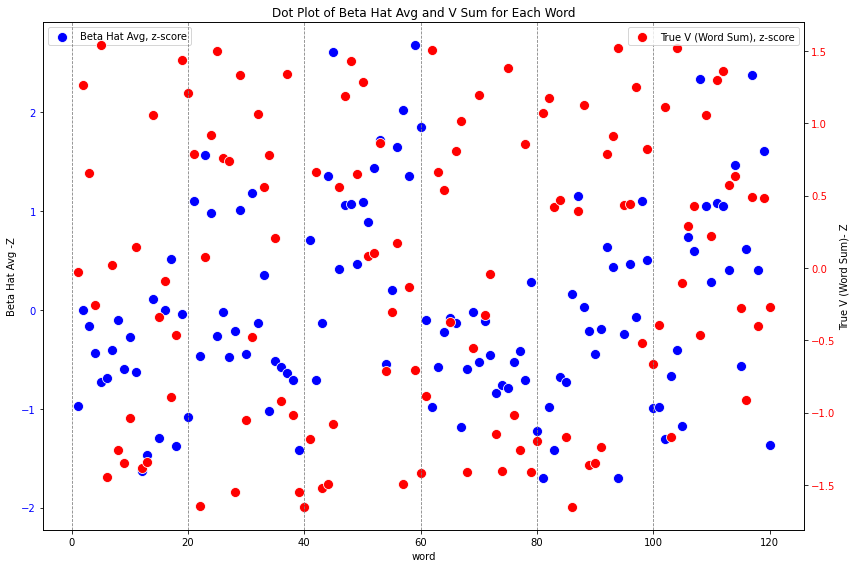

In [18]:
true_word_sum = Vtrue_train.sum(axis=0).values

b2_benchmark_df = pd.DataFrame(b2_avg, columns = ['beta_hat_avg'])
b2_benchmark_df['word'] = range(len(b2_avg))
b2_benchmark_df['word'] = b2_benchmark_df['word']+1
b2_benchmark_df['v_sum'] = true_word_sum

################################################################################################
# Set the plot size
plt.figure(figsize=(12, 8))

# Create the first axis for 'beta_hat_avg'
ax1 = plt.gca()  # Get current axis

mean_beta_hat_avg = b2_benchmark_df['beta_hat_avg'].mean()
std_beta_hat_avg = b2_benchmark_df['beta_hat_avg'].std()

# Calculate the z-score
b2_benchmark_df['beta_hat_avg_z'] = (b2_benchmark_df['beta_hat_avg'] - mean_beta_hat_avg) / std_beta_hat_avg



mean_v_sum = b2_benchmark_df['v_sum'].mean()
std_v_sum = b2_benchmark_df['v_sum'].std()

# Calculate the z-score
b2_benchmark_df['v_sum_z'] = (b2_benchmark_df['v_sum'] - mean_v_sum) / std_v_sum


sns.scatterplot(x='word', y='beta_hat_avg_z', data=b2_benchmark_df, ax=ax1, color='blue', label='Beta Hat Avg, z-score', s=100)
ax1.set_ylabel('Beta Hat Avg -Z')
ax1.set_title('Dot Plot of Beta Hat Avg and V Sum for Each Word')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for 'v_sum'
ax2 = ax1.twinx()  # Create a new axes sharing the same x-axis
sns.scatterplot(x='word', y='v_sum_z', data=b2_benchmark_df, ax=ax2, color='red', label='True V (Word Sum), z-score', s=100)
ax2.set_ylabel('True V (Word Sum)- Z')
ax2.tick_params(axis='y', labelcolor='red')

# Optional: Adjust the limits of both axes for better visualization
#ax1.set_ylim(b2_benchmark_df['beta_hat_avg'].min() - 1, b2_benchmark_df['beta_hat_avg'].max() + 1)  # Adjust y-limits for beta_hat_avg
#ax2.set_ylim(b2_benchmark_df['v_sum_z'].min() - 1, b2_benchmark_df['v_sum_z'].max() + 1)  # Adjust y-limits for v_sum

# Show the legend
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Add vertical lines at specified x-values
for x in [0, 20, 40, 60, 80, 100]:
    plt.axvline(x=x, color='gray', linestyle='--', linewidth=0.8)

    
# Rotate x-axis labels for better visibility
plt.xticks(rotation=90)

# Display the plot
plt.tight_layout()
plt.show()

# Scenario 1 -- SNMF

In [19]:
# Adjust the figure folder path to a location where permissions are not an issue
fig_folder = '/ix1/ltang/ziz60/nmf_causal_eval/20_simple_scenario_underfitted/output24/'  # Local directory where we should have permission

# Ensure the fig_folder directory exists
os.makedirs(fig_folder, exist_ok=True)

# Update PDF paths with the new directory
hist_pdf_path = f'{fig_folder}fig/all_hist_plots.pdf'
one_sd_pdf_path = f'{fig_folder}fig/all_one_sd_plots.pdf'

# Initialize PDF files for plots
hist_pdf = PdfPages(hist_pdf_path)
one_sd_pdf = PdfPages(one_sd_pdf_path)

# Initialize empty lists to store the reports from each iteration
all_test_results = []
all_train_results = []
all_validation_results = []
output_ls = [None]* 200
U_validation_sim_ls  = [None]* 200
U_test_ls =  [None]* 200
# Function to evaluate and generate plots


base_path_1 = '/ix1/ltang/ziz60/nmf_causal_eval/20_simple_scenario_underfitted/output24/'

scenario = 'scenario1_r3_sim'
joblib_extension = '.joblib'

# Loop to run the eval_function with different values of i
for i in range(100): # !!! TODO Change the number of simulations to load
    try:
        eval_function(i, base_path_1, hist_pdf, one_sd_pdf, benchmark=False)
    except FileNotFoundError as e:
        print(f"File not found for i={i}: {e}. Skipping to the next.")
        continue
# Close the PDF files
hist_pdf.close()
one_sd_pdf.close()

print(f"All hist plots saved to {hist_pdf_path}")
print(f"All one_sd plots saved to {one_sd_pdf_path}")


alpha_grid = all_train_results[0]['alpha1'].unique()
lambda_grid = all_train_results[0]['lambda'].unique()

snmf_train_results = pd.concat(all_train_results, ignore_index=True)
snmf_validation_results = pd.concat(all_validation_results, ignore_index=True)
snmf_test_results = pd.concat(all_test_results, ignore_index=True)

num_sim = len(snmf_test_results['simulation'].unique())
print(num_sim)


Loading: /ix1/ltang/ziz60/nmf_causal_eval/20_simple_scenario_underfitted/output24/scenario1_r3_sim_0_100_1000.joblib
Alpha values: [1.e-07 1.e+00]
Lambda values: [1.e-10 1.e-05]
Loading: /ix1/ltang/ziz60/nmf_causal_eval/20_simple_scenario_underfitted/output24/scenario1_r3_sim_1_101_1001.joblib
Alpha values: [1.e-07 1.e+00]
Lambda values: [1.e-10 1.e-05]
Loading: /ix1/ltang/ziz60/nmf_causal_eval/20_simple_scenario_underfitted/output24/scenario1_r3_sim_2_102_1002.joblib
Alpha values: [1.e-07 1.e+00]
Lambda values: [1.e-10 1.e-05]
Loading: /ix1/ltang/ziz60/nmf_causal_eval/20_simple_scenario_underfitted/output24/scenario1_r3_sim_3_103_1003.joblib
Alpha values: [1.e-07 1.e+00]
Lambda values: [1.e-10 1.e-05]
Loading: /ix1/ltang/ziz60/nmf_causal_eval/20_simple_scenario_underfitted/output24/scenario1_r3_sim_4_104_1004.joblib
Alpha values: [1.e-07 1.e+00]
Lambda values: [1.e-10 1.e-05]
Loading: /ix1/ltang/ziz60/nmf_causal_eval/20_simple_scenario_underfitted/output24/scenario1_r3_sim_5_105_1005.

In [20]:
####################################################
criteria = "largest" ##TODO: change EVALUATIOn criteria!!!!
#criteria = "smallest" ##TODO: change EVALUATIOn criteria!!!!

snmf_validation_results_optimal = snmf_validation_results[snmf_validation_results['within_1sd_TF'] == True]

# largest alpha and lambda
if criteria == "largest":
    snmf_validation_results_optimal = snmf_validation_results_optimal.groupby('simulation').apply(
        lambda x: x.sort_values(by=['lambda', 'alpha1'], ascending=False).head(1)
    ).reset_index(drop=True)

elif criteria == "smallest":
    snmf_validation_results_optimal = snmf_validation_results_optimal.groupby('simulation').apply(
        lambda x: x.sort_values(by=['lambda', 'alpha1'], ascending=True).head(1)
    ).reset_index(drop=True)

    
simulation_ls = snmf_validation_results_optimal["simulation"]
output_optimal_ls = [None]*200
U_train_optimal_ls = [None]*200
U_test_optimal_ls = [None]*200
U_validation_i_optimal_ls= [None]*200
V_optimal_ls = []
b2_optimal_ls = []


snmf_test_results_optimal = []

for i, sim in enumerate(simulation_ls):
   # print("Simulation # ",sim)
    output_i = output_ls[sim]
    
    snmf_validation_results_optimal_i = snmf_validation_results_optimal[snmf_validation_results_optimal['simulation']==sim]
    snmf_test_results_optimal_i = snmf_test_results[snmf_test_results['simulation'] == sim]
    
    U_test_i = U_test_ls[sim] # !!!TODO: change this for output 5
    U_validation_i = U_validation_sim_ls[sim] # !!!TODO: change this for output 5
        
    alpha_optimal = snmf_validation_results_optimal_i[['alpha1']].iloc[0,0]
    alpha_index = np.where(alpha_grid == alpha_optimal)[0][0]

    #print("alpha_optimal=", alpha_optimal, ". Index:",alpha_index )

    lambda_optimal = snmf_validation_results_optimal_i[['lambda']].iloc[0,0]
    lambda_index = np.where(lambda_grid == lambda_optimal)[0][0]
    #print("lambda_optimal=", lambda_optimal, ". Index:",lambda_index )

    optimal_output_i = output_i[alpha_index][lambda_index]
    output_optimal_ls[sim] = optimal_output_i
    snmf_test_results_optimal_i = snmf_test_results_optimal_i[
        (snmf_test_results_optimal_i['alpha'] == alpha_optimal) & 
        (snmf_test_results_optimal_i['lambda'] == lambda_optimal)
    ]
    snmf_test_results_optimal_i['simulation'] = sim
    snmf_test_results_optimal.append(snmf_test_results_optimal_i)
    
    U_train_optimal_i = optimal_output_i[2]
    U_train_optimal_ls[sim] = U_train_optimal_i
    U_validation_i_optimal_ls[sim] = U_validation_i[alpha_index][lambda_index] # !!!TODO: change this for output 5
    U_test_opt = U_test_i[alpha_index][lambda_index]# !!!TODO: change this for output 5
    U_test_optimal_ls[sim] = U_test_opt# !!!TODO: change this for output 5
    
    V_optimal_i = optimal_output_i[3]
    V_2stage_r = reorder_V(Vtrue_train, V_optimal_i, m2, True)
    V_2stage_R = reorder_V(Vtrue_train, V_optimal_i, m2, False)
    V_optimal_ls.append(V_2stage_R)

    b2_out_i = optimal_output_i[4]
    b2_out_i_r = reorder_beta(Vtrue_train, V_optimal_i, b2_out_i, m1, m2, True)
    b2_out_i_R = reorder_beta(Vtrue_train, V_optimal_i, b2_out_i, m1, m2, False)
    b2_optimal_ls.append(b2_out_i_R)
    
snmf_test_results_optimal = pd.concat(snmf_test_results_optimal, ignore_index=True)

    
# get the average beta hat, used for colorbar
b2_optimal_ls= np.array(b2_optimal_ls)
b2_optimal = b2_optimal_ls.reshape(len(b2_optimal_ls), len(b2_optimal_ls[0])) # reshape b2_optimal_ls
b2_optimal = pd.DataFrame(b2_optimal)
b2_optimal = b2_optimal.iloc[:, m1+1:]
b2_avg = b2_optimal.abs().mean(axis=0).values


snmf_test_results = snmf_test_results_optimal[['rmse', 'accuracy_dx','specificity','sensitivity', 'classification_error','v_minus_vhat_norm','x2_minus_uv_norm']]
snmf_test_results['method'] = "snmf"


###############################################################################
# Calculate the mean
mean_value = snmf_test_results_optimal['rmse'].mean()
std_dev = snmf_test_results_optimal['rmse'].std()

print(f"RMSE Mean: {mean_value}")
print(f"RMSE Standard Deviation: {std_dev}")

# Calculate the mean
mean_value = snmf_test_results_optimal['classification_error'].mean()
std_dev = snmf_test_results_optimal['classification_error'].std()

print(f"CE Mean: {mean_value}")
print(f"CE Standard Deviation: {std_dev}")

# Calculate the mean
mean_value = snmf_test_results_optimal['v_minus_vhat_norm'].mean()
std_dev = snmf_test_results_optimal['v_minus_vhat_norm'].std()

print(f"V ERROR: Mean: {mean_value}")
print(f"V ERROR: Standard Deviation: {std_dev}")

# Calculate the mean
mean_value = snmf_test_results_optimal['x2_minus_uv_norm'].mean()
std_dev = snmf_test_results_optimal['x2_minus_uv_norm'].std()

print(f"X2 ERROR: Mean: {mean_value}")
print(f"X2 ERROR: Standard Deviation: {std_dev}")

RMSE Mean: 18.302765393001547
RMSE Standard Deviation: 0.19718090561805532
CE Mean: 0.18257575757575759
CE Standard Deviation: 0.010088763251231233
V ERROR: Mean: 0.018232773849244092
V ERROR: Standard Deviation: 0.00805215729362111
X2 ERROR: Mean: 0.0010350733758026885
X2 ERROR: Standard Deviation: 6.906366209023195e-05


<ipython-input-20-1804493d74ac>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  snmf_test_results['method'] = "snmf"


In [21]:
snmf_test_results

,rmse,accuracy_dx,specificity,sensitivity,classification_error,v_minus_vhat_norm,x2_minus_uv_norm,method
0,18.356728,0.8275,0.875522,0.755915,0.1725,0.002984,0.001133,snmf
1,18.367747,0.8050,0.857143,0.730583,0.1950,0.022055,0.000980,snmf
2,18.215953,0.8245,0.886441,0.735366,0.1755,0.022659,0.001050,snmf
3,18.327755,0.8045,0.862890,0.713555,0.1955,0.022504,0.001043,snmf
4,18.319782,0.8180,0.885522,0.719212,0.1820,0.022781,0.001011,snmf
5,18.162578,0.8240,0.870355,0.752852,0.1760,0.002642,0.001125,snmf
6,17.931447,0.8140,0.872937,0.723350,0.1860,0.002699,0.001151,snmf
7,18.357801,0.8130,0.866221,0.733831,0.1870,0.022407,0.000990,snmf
8,18.491996,0.8085,0.873746,0.711443,0.1915,0.022555,0.001042,snmf
9,18.340012,0.8205,0.873896,0.732450,0.1795,0.022551,0.001039,snmf


In [22]:
snmf_validation_results_optimal['lambda_alpha'].value_counts()


lambda1e-05_alpha1e-07    14
lambda1e-10_alpha1e-07    11
lambda1e-05_alpha1.0       8
Name: lambda_alpha, dtype: int64

# Scenario 1
## Two-Stage NMF

In [23]:
vsignal = v_signal_val


# Initialize lists to store results from each simulation
results = []
V_2s_list = []
U_2s_list = []
b2_2s_list = []

# Run 10 simulations with different seeds
for i in range(100):
    seed_train = i
    seed_test = 1000 + i

    # Generate training and testing data
    data_train, Vtrue_train, NA, rmse_min_train = generate_data_dlearning(seed=seed_train, n=n, r=R, m1=m1, m2=m2, zeta1=1, zeta2=2,
                                    main_topic_signal=main_topic_signal, topic_weights=topic_weights, eta=eta, epsilon=epsilon, gamma1=gamma1, gamma2=gamma2,
                                    beta0=beta0, psi1=psi1, psi2=psi2, beta1=beta1, beta2=beta2, beta3=beta3, beta4=beta4, beta5=beta5, rho1=rho1, rho2=rho2, rho3=rho3, v_signal_val=v_signal_val, scenario="D", sparse = True, correlation_type=correlation_type)
    
    data_test, Vtrue_test, NA, rmse_min_test = generate_data_dlearning(seed=seed_test, n=n, r=R, m1=m1, m2=m2, zeta1=1, zeta2=2,
                                    main_topic_signal=main_topic_signal, topic_weights=topic_weights, eta=eta, epsilon=epsilon, gamma1=gamma1, gamma2=gamma2,
                                    beta0=beta0, psi1=psi1, psi2=psi2, beta1=beta1, beta2=beta2, beta3=beta3, beta4=beta4, beta5=beta5, rho1=rho1, rho2=rho2, rho3=rho3, v_signal_val=v_signal_val, scenario="D", sparse = True, correlation_type=correlation_type)
   
    
    # Run the 2-stage NMF model
    accuracy_train, rmse_train,  specificity_test, sensitivity_test, accuracy_test, rmse_test, classification_error_test,v_minus_vhat_norm, V_2stage_r, beta_2stage_r,  beta_2stage_R, x2_minus_uv_norm = run_2s_nmf(data_train, data_test, Vtrue_train, m1, m2, R, 3)
        
    V_2s_list.append(V_2stage_R)
    #U_2s_list.append(U_out_R)
    b2_2s_list.append(beta_2stage_R)

    # Store results in a dictionary
    results.append({
        'seed_train': seed_train,
        'seed_test': seed_test,
        'specificity': specificity_test,
        'sensitivity': sensitivity_test,
        'accuracy_dx': accuracy_test,
        'rmse': rmse_test,
        'classification_error':classification_error_test,
        'v_minus_vhat_norm' : v_minus_vhat_norm,
        'x2_minus_uv_norm' : x2_minus_uv_norm
        # Add other results if needed
    })

# Concatenate all results into a single DataFrame
results_df = pd.DataFrame(results)

twostage_test_results = results_df[['rmse', 'accuracy_dx','specificity','sensitivity', 'classification_error', 'v_minus_vhat_norm','x2_minus_uv_norm']]
twostage_test_results['method'] = "two_stage"

    
# get the average beta hat, used for colorbar
b2_2s_list= np.array(b2_2s_list)
b2_2s = b2_2s_list.reshape(len(b2_2s_list), len(b2_2s_list[0])) # reshape b2_optimal_ls
b2_2s = pd.DataFrame(b2_2s)
b2_2s = b2_2s.iloc[:, m1+1:]
b2_2s_avg = b2_2s.abs().mean(axis=0).values



!!!At iteration 0 Absolute difference in current objective and previous objective / initial objective= 0.0 , END!!!
V hat has shape:  (3, 120)
V true has shape:  (6, 120)
V_r has shape:  (6, 120)
Since r<R, reorder V hat and then compute v_minus_vhat.
!!!At iteration 0 Absolute difference in current objective and previous objective / initial objective= 0.0 , END!!!
V hat has shape:  (3, 120)
V true has shape:  (6, 120)
V_r has shape:  (6, 120)
Since r<R, reorder V hat and then compute v_minus_vhat.
!!!At iteration 0 Absolute difference in current objective and previous objective / initial objective= 0.0 , END!!!
V hat has shape:  (3, 120)
V true has shape:  (6, 120)
V_r has shape:  (6, 120)
Since r<R, reorder V hat and then compute v_minus_vhat.
!!!At iteration 0 Absolute difference in current objective and previous objective / initial objective= 0.0 , END!!!
V hat has shape:  (3, 120)
V true has shape:  (6, 120)
V_r has shape:  (6, 120)
Since r<R, reorder V hat and then compute v_minu

<ipython-input-23-76bf59d68bff>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  twostage_test_results['method'] = "two_stage"


In [24]:
# get the average beta hat, used for colorbar
b2_2s_list= np.array(b2_2s_list)
b2_2s = b2_2s_list.reshape(len(b2_2s_list), len(b2_2s_list[0])) # reshape b2_optimal_ls
b2_2s = pd.DataFrame(b2_2s)
b2_2s = b2_2s.iloc[:, m1+1:]
b2_2s_avg = b2_2s.abs().mean(axis=0).values


In [25]:
combined_results = pd.concat([snmf_test_results, twostage_test_results, benchmark_test_results], axis=0, ignore_index=True)


V_snmf_list =V_optimal_ls


# SNMF
# Step 1: Normalize each V in V_snmf_list by its column norm
V_snmf_normalized_list = []

for V in V_snmf_list:
    # Calculate the norm of each column
    column_norms =np.linalg.norm(V, axis=1, keepdims=True)
    # Normalize each column of V
    V_normalized = V / column_norms
    # Add the normalized V to the list
    V_snmf_normalized_list.append(V_normalized)

    
# Step 2: Calculate the element-wise average of all normalized V matrices
if len(V_snmf_normalized_list) > 0:
    # Initialize V_avg with zeros of the same shape as the first normalized matrix
    V_avg = np.zeros_like(V_snmf_normalized_list[0])

    # Sum up all normalized matrices element-wise
    for V_normalized in V_snmf_normalized_list:
        V_normalized = np.nan_to_num(V_normalized, nan=0)
        V_avg += V_normalized

    # Divide by the number of matrices to get the average
    V_avg /= len(V_snmf_normalized_list)

    print("V_avg constructed successfully.")
else:
    print("V_snmf_normalized_list is empty. Cannot construct V_avg.")
    
V_snmf_avg = V_avg



###############################################################
# TWO - STAGE
#Step 1: Normalize each V in V_snmf_list by its column norm
V_2s_normalized_list = []

for V in V_2s_list:
    # Calculate the norm of each column
    column_norms =np.linalg.norm(V, axis=1, keepdims=True)    
    # Normalize each column of V
    V_normalized = V / column_norms
    
    # Add the normalized V to the list
    V_2s_normalized_list.append(V_normalized)
    
    
V_2s_normalized_list  = V_2s_list
# Step 2: Calculate the element-wise average of all normalized V matrices
if len(V_2s_normalized_list) > 0:
    # Initialize V_avg with zeros of the same shape as the first normalized matrix
    V_avg = np.zeros_like(V_2s_normalized_list[0])

    # Sum up all normalized matrices element-wise
    for V_normalized in V_2s_normalized_list:
        V_avg += V_normalized

    # Divide by the number of matrices to get the average
    V_avg /= len(V_2s_normalized_list)

    print("V_avg constructed successfully.")
else:
    print("V_snmf_normalized_list is empty. Cannot construct V_avg.")
    
V_2s_avg = V_avg
#####################################################################
# V plot -- top words
# takes three V matrics: 1. Vtrue_train, 2.V_2stage_r, 3.V_snmf_r
Vtrue_df = Vtrue_train.T
Vtrue_df.reset_index(inplace=True)
# Rename the column 'index' to whatever you prefer, e.g., 'row_name'
Vtrue_df.rename(columns={'index': 'word'}, inplace=True)
# Create a dictionary with the new column names
new_column_names = {
    0: 'T1',
    1: 'T2',
    2: 'T3',
    3: 'T4',
    4: 'T5',
    5: 'T6',
   
}
# Rename all columns
Vtrue_df.rename(columns=new_column_names, inplace=True)
###################################################################
#norms = np.linalg.norm(V_2stage_r, axis=1, keepdims=True)
#V_2stage_r_norm = V_2stage_r/ norms
V_2s_df = pd.DataFrame(V_2s_avg.T)
    
num_rows = len(V_2s_df)
V_2s_df[['word']] = ['word_' + str(i+1) for i in range(num_rows)]

# Create a dictionary with the new column names
new_column_names = {
    0: 'T1',
    1: 'T2',
    2: 'T3',
    3: 'T4',
    4: 'T5',
    5: 'T6',
   
}

# Rename all columns
V_2s_df.rename(columns=new_column_names, inplace=True)
###################################################################
#norms = np.linalg.norm(V_snmf_r, axis=1, keepdims=True)
#V_snmf_r_norm = V_snmf_r/ norms
V_snmf_df = pd.DataFrame(V_snmf_avg.T)

num_rows = len(V_snmf_df)
V_snmf_df[['word']] = ['word_' + str(i+1) for i in range(num_rows)]
new_column_names = {
    0: 'T1',
    1: 'T2',
    2: 'T3',
    3: 'T4',
    4: 'T5',
    5: 'T6',
   
}

# Rename all columns
V_snmf_df.rename(columns=new_column_names, inplace=True)

# Set 'word' column as the index to use it as row labels
V_2s_df.set_index('word', inplace=True)
V_snmf_df.set_index('word', inplace=True)
Vtrue_df.set_index('word', inplace=True)



Vtrue_df_scen1 = Vtrue_df.copy()
V_snmf_df_scen1 = V_snmf_df.copy()
V_2s_df_scen1 = V_2s_df.copy()

b2_avg_scen1 = b2_avg.copy()
b2_2s_avg_scen1 = b2_2s_avg.copy()

combined_results_scen1 = combined_results.copy()

V_avg constructed successfully.
V_avg constructed successfully.


<ipython-input-25-33540c0b7a53>:15: RuntimeWarning: invalid value encountered in divide
  V_normalized = V / column_norms
<ipython-input-25-33540c0b7a53>:50: RuntimeWarning: invalid value encountered in divide
  V_normalized = V / column_norms


# Two plots together

In [36]:

print(b2_avg_scen1)
print(b2_2s_avg_scen1)

print(b2_avg_scen2)
print(b2_2s_avg_scen2)

combined_results_scen1_sub = combined_results_scen1[['v_minus_vhat_norm', 'x2_minus_uv_norm', 'method']]
combined_results_scen1_sub = combined_results_scen1_sub[combined_results_scen1_sub['method'].isin(['snmf', 'two_stage'])]


combined_results_scen2_sub = combined_results_scen2[['v_minus_vhat_norm', 'x2_minus_uv_norm', 'method']]
combined_results_scen2_sub = combined_results_scen2_sub[combined_results_scen2_sub['method'].isin(['snmf', 'two_stage'])]

combined_results_scen1_sub

[0.87275623 0.97853271 0.03595019 0.34741411 0.06810259 1.09805779]
[0.14439765 0.17226049 0.13685191 0.04423125 0.09010754 0.12197859]
[0.72411601 0.8515842  0.44650625 0.70759565 0.77615866]
[0.15933196 0.15381765 0.18630398 0.15833042 0.18042658]


,v_minus_vhat_norm,x2_minus_uv_norm,method
0,0.002984,0.001133,snmf
1,0.022055,0.000980,snmf
2,0.022659,0.001050,snmf
3,0.022504,0.001043,snmf
4,0.022781,0.001011,snmf
...,...,...,...
128,0.047373,0.001857,two_stage
129,0.047717,0.001816,two_stage
130,0.047919,0.001938,two_stage
131,0.049963,0.001568,two_stage


<ipython-input-39-896970f7d9a0>:106: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs2[3].set_yticklabels([f"{tick:.1e}" for tick in axs2[3].get_yticks()])
<ipython-input-39-896970f7d9a0>:208: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs4[3].set_yticklabels([f"{tick:.1e}" for tick in axs4[3].get_yticks()])
<ipython-input-39-896970f7d9a0>:247: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


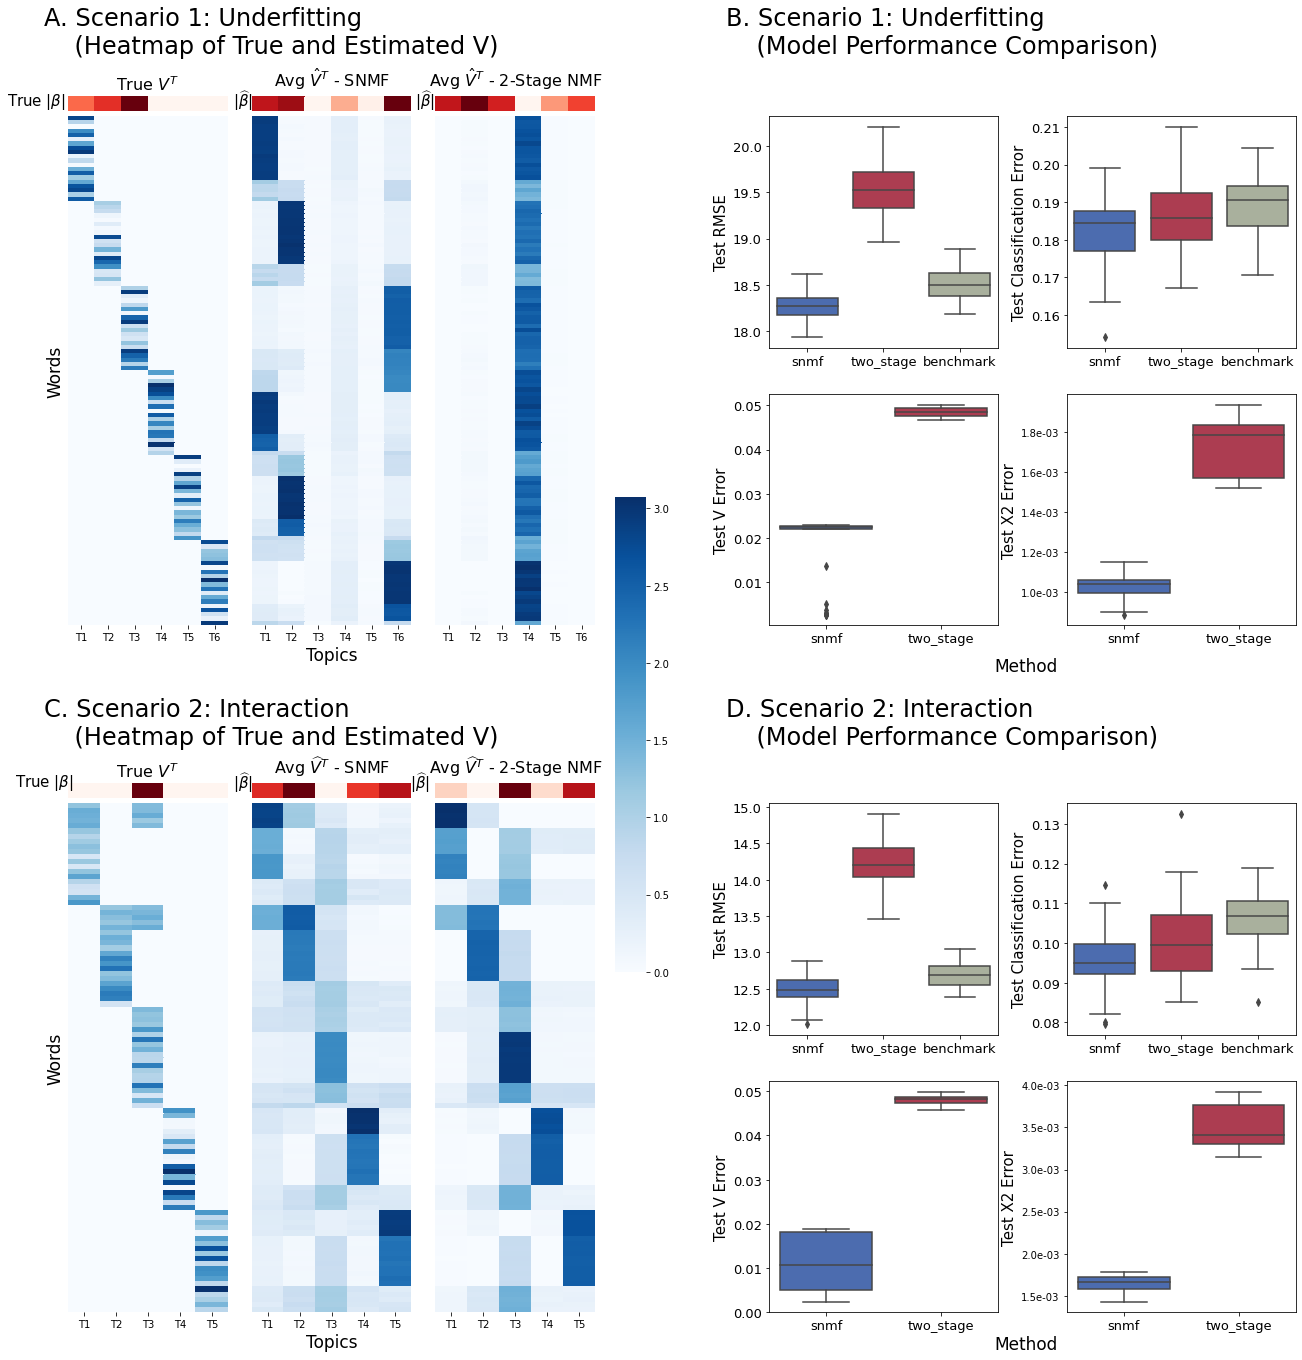

In [39]:
# Create a custom colormap
custom_colors = ['#3B67BF', '#BF2A45','#aab39a']
true_beta_color_scen1 = [4, 7, 10, 0, 0]
true_beta_color_scen2 = [0, 0, 10, 0, 0]



# Create the main figure with two columns of subplots
fig = plt.figure(figsize=(22, 22), constrained_layout=False)

# Define a GridSpec with 1 row and 2 columns for side-by-side plots
gs = fig.add_gridspec(2, #number of rows
                      2, #number of columns
                      width_ratios=[1, 1], #ratio between two plots;
                      height_ratios=[1, 1], #ratio between two plots;
                      wspace=0.33, #controls the space in between left and right
                      hspace = 0.35 #controls the space in top and bottom plots
                     ) 

################################################################################
################### Plot A. (Heatma. Underfitted Scenario)######################
################################################################################
# Left subplot for the heatmaps
ax1 = fig.add_subplot(gs[0, 0])

# Create the heatmaps# Create the heatmaps directly into ax1's gridspec
gs1_left = ax1.get_gridspec()

# Create a new axes for the heatmaps inside ax1
subgs1 = gs1_left[0].subgridspec(1, 3, width_ratios=[1, 1, 1], wspace=0.15)
axs1 = [fig.add_subplot(subgs1[0, i]) for i in range(3)]

sns.heatmap(Vtrue_df_scen1 , annot=False, cmap='Blues', fmt='.2f', ax=axs1[0], cbar=False)
sns.heatmap(V_snmf_df_scen1 , annot=False, cmap='Blues', fmt='.2f', ax=axs1[1], cbar=False)
sns.heatmap(V_2s_df_scen1 , annot=False, cmap='Blues', fmt='.2f', ax=axs1[2], cbar=False)

# Set titles
axs1[0].set_title('True $V^T$', fontsize=16)
axs1[1].set_title(r'Avg $\hat{V}^T$ - SNMF', pad=30, fontsize=16)
axs1[2].set_title(r'Avg $\hat{V}^T$ - 2-Stage NMF', pad=30, fontsize=16)

# Remove x-axis ticks and labels for all heatmaps
for ax in axs1:
    ax.set_yticks([])
    ax.set_ylabel("")
    ax.set_xlabel("")

# Set the common y-axis label for the first plot only
axs1[0].set_ylabel('Words', fontsize=17)
axs1[1].set_xlabel('Topics', fontsize=17)

# Create a color strip above the first heatmap to indicate "true beta" values
true_beta = [-15, 20, -30, 0, 0]
true_beta_color = [15, 20, 30, 0, 0,0]

# Color strip of true beta on top of the first heatmap
cbar_ax = axs1[0].inset_axes([0, 1.01, 1, 0.03]) # [left, bottom, width, height]
sns.heatmap(np.array([true_beta_color]), ax=cbar_ax, cmap="Reds", cbar=False, xticklabels=False, yticklabels=False)
cbar_ax = axs1[1].inset_axes([0, 1.01, 1, 0.03])
sns.heatmap(np.array([b2_avg_scen1]), ax=cbar_ax, cmap="Reds", cbar=False, xticklabels=False, yticklabels=False)
cbar_ax = axs1[2].inset_axes([0, 1.01, 1, 0.03])
sns.heatmap(np.array([b2_2s_avg_scen1]), ax=cbar_ax, cmap="Reds", cbar=False, xticklabels=False, yticklabels=False)


# Add the title for the color strips
fig.text(0.105, 0.89, r'True $|\beta|$', fontsize=15, ha='center', va='center')
fig.text(0.235, 0.89, r'$|\widehat{\beta}|$', fontsize=15, ha='center', va='center')
fig.text(0.35, 0.89, r'$|\widehat{\beta}|$', fontsize=15, ha='center', va='center')

# Add the beta values as text on the color strip
#for i, value in enumerate(true_beta):
#    cbar_ax.text(i + 0.5, 0.5, f'{value}', ha='center', va='center', fontsize=10, color='black', weight='bold')

################################################################################
################### Plot B. (Evaluation Criteria. Underfitted Scenario)#########
################################################################################
# Right subplot for the boxplots
ax2 = fig.add_subplot(gs[0, 1])

# Create a new gridspec for the 2x2 boxplots inside ax2
subgs2 = gs[0, 1].subgridspec(2, 2, wspace=0.3)

axs2 = [fig.add_subplot(subgs2[i, j]) for i in range(2) for j in range(2)]

# Plot 2: Boxplot for Classification Error, colored by method
# Plot 1: Boxplot for RMSE, colored by method
sns.boxplot(x='method', y='rmse', data=combined_results_scen1, ax=axs2[0], palette=custom_colors, showfliers=False)
axs2[0].set_xlabel('Method', fontsize=15)
axs2[0].set_ylabel('Test RMSE', fontsize=15)
axs2[0].tick_params(axis='both', labelsize=13)

# Plot 2: Boxplot for Classification Error, colored by method
sns.boxplot(x='method', y='classification_error', data=combined_results_scen1, ax=axs2[1], palette=custom_colors)
axs2[1].set_xlabel('Method', fontsize=15)
axs2[1].set_ylabel('Test Classification Error', fontsize=15)
axs2[1].tick_params(axis='both', labelsize=13)

# Plot 3: Boxplot for v_minus_vhat_norm, colored by method
sns.boxplot(x='method', y='v_minus_vhat_norm', data=combined_results_scen1_sub, ax=axs2[2], palette=custom_colors)
axs2[2].set_xlabel('Method', fontsize=15)
axs2[2].set_ylabel('Test V Error', fontsize=15)
axs2[2].tick_params(axis='both', labelsize=13)

# Plot 4: Boxplot for x2_minus_uv_norm, colored by method
sns.boxplot(x='method', y='x2_minus_uv_norm', data=combined_results_scen1_sub, ax=axs2[3], palette=custom_colors)
axs2[3].set_yticklabels([f"{tick:.1e}" for tick in axs2[3].get_yticks()])
axs2[3].set_xlabel('Method', fontsize=15)
axs2[3].set_ylabel('Test X2 Error', fontsize=15)
axs2[3].tick_params(axis='x', labelsize=13)# make the labelsize smaller so it can fit
axs2[3].tick_params(axis='y', labelsize=10)# make the labelsize smaller so it can fit

# Remove x-axis ticks and labels for all heatmaps
for ax in axs2:
    ax.set_xlabel("")

# Set the common x-axis label 
fig.text(0.71, 0.53, f'Method', fontsize=17)


################################################################################
################### Plot C. (Heatmap. Interaction Scenario)#####################
################################################################################
# Left subplot for the heatmaps
# ax3 = fig.add_subplot(gs[1, 0])
# # Create the heatmaps# Create the heatmaps directly into ax3's gridspec
# gs3_left = ax3.get_gridspec()
# # Create a new axes for the heatmaps inside ax3
# subgs3 = gs3_left[0].subgridspec(1, 3, width_ratios=[1, 1, 1], wspace=0.1)
# axs3 = [fig.add_subplot(subgs3[0, i]) for i in range(3)]


# Instead of creating ax3 directly, define a subgridspec for the heatmaps in the bottom left
subgs3 = gs[1, 0].subgridspec(1, 3, width_ratios=[1, 1, 1], wspace=0.15)
# Now create the heatmap subplots in the left bottom
axs3 = [fig.add_subplot(subgs3[0, i]) for i in range(3)]


sns.heatmap(Vtrue_df_scen2, annot=False, cmap='Blues', fmt='.2f', ax=axs3[0], cbar=False)
sns.heatmap(V_snmf_df_scen2, annot=False, cmap='Blues', fmt='.2f', ax=axs3[1], cbar=False)
sns.heatmap(V_2s_df_scen2, annot=False, cmap='Blues', fmt='.2f', ax=axs3[2], cbar=True, cbar_ax=fig.add_axes([0.47, 0.34, 0.02, 0.3]))

# Set titles 
axs3[0].set_title('True $V^T$', fontsize=16)
axs3[1].set_title(r'Avg $\widehat{V}^T$ - SNMF', pad=30, fontsize=16)
axs3[2].set_title(r'Avg $\widehat{V}^T$ - 2-Stage NMF', pad=30, fontsize=16)


# Remove x-axis ticks and labels for all heatmaps
for ax in axs3:
    ax.set_yticks([])
    ax.set_ylabel("")
    ax.set_xlabel("")

# Set the common y-axis label for the first plot only
axs3[0].set_ylabel('Words', fontsize=17)
axs3[1].set_xlabel('Topics', fontsize=17)


# Color strip of true beta on top of the first heatmap
true_beta_color_scen2 = [0, 0, 30, 0, 0] #absolute value of the true beta coefficients
cbar_ax = axs3[0].inset_axes([0, 1.01, 1, 0.03]) #[bottom left x-position, bottom left y-position, width, height]
sns.heatmap(np.array([true_beta_color_scen2]), ax=cbar_ax, cmap="Reds", cbar=False, xticklabels=False, yticklabels=False)
cbar_ax = axs3[1].inset_axes([0, 1.01, 1, 0.03]) #[bottom left x-position, bottom left y-position, width, height] #[bottom left x-position, bottom left y-position, width, height]
sns.heatmap(np.array([b2_avg_scen2]), ax=cbar_ax, cmap="Reds", cbar=False, xticklabels=False, yticklabels=False)
cbar_ax = axs3[2].inset_axes([0, 1.01, 1, 0.03]) #[bottom left x-position, bottom left y-position, width, height]
sns.heatmap(np.array([b2_2s_avg_scen2]), ax=cbar_ax, cmap="Reds", cbar=False, xticklabels=False, yticklabels=False)

# Add the title for the color strips
fig.text(0.11, 0.46, r'True $|\beta|$', fontsize=15, ha='center', va='center')
fig.text(0.235, 0.46, r'$|\widehat{\beta}|$', fontsize=15, ha='center', va='center')
fig.text(0.347, 0.46, r'$|\widehat{\beta}|$', fontsize=15, ha='center', va='center')
# Add the beta values as text on the color strip
# for i, value in enumerate(true_beta):
#     cbar_ax.text(i + 0.5, 0.5, f'{value}', ha='center', va='center', fontsize=10, color='black', weight='bold')

################################################################################
################### Plot D. (Evaluation Criteria. Interaction Scenario)#########
################################################################################
# Right subplot for the boxplots
ax4= fig.add_subplot(gs[1, 1])

# Create a new gridspec for the 2x2 boxplots inside ax4
subgs4 = gs[1, 1].subgridspec(2, 2, wspace=0.3)

axs4 = [fig.add_subplot(subgs4[i, j]) for i in range(2) for j in range(2)]

# Plot 2: Boxplot for Classification Error, colored by method
# Plot 1: Boxplot for RMSE, colored by method
sns.boxplot(x='method', y='rmse', data=combined_results_scen2, ax=axs4[0], palette=custom_colors)
axs4[0].set_xlabel('Method', fontsize=15)
axs4[0].set_ylabel('Test RMSE', fontsize=15)
axs4[0].tick_params(axis='both', labelsize=13)

# Plot 2: Boxplot for Classification Error, colored by method
sns.boxplot(x='method', y='classification_error', data=combined_results_scen2, ax=axs4[1], palette=custom_colors)
axs4[1].set_xlabel('Method', fontsize=15)
axs4[1].set_ylabel('Test Classification Error', fontsize=15)
axs4[1].tick_params(axis='both', labelsize=13)

# Plot 3: Boxplot for v_minus_vhat_norm, colored by method
sns.boxplot(x='method', y='v_minus_vhat_norm', data=combined_results_scen2_sub, ax=axs4[2], palette=custom_colors)
axs4[2].set_xlabel('Method', fontsize=15)
axs4[2].set_ylabel('Test V Error', fontsize=15)
axs4[2].tick_params(axis='both', labelsize=13)

# Plot 4: Boxplot for x2_minus_uv_norm, colored by method
sns.boxplot(x='method', y='x2_minus_uv_norm', data=combined_results_scen2_sub, ax=axs4[3], palette=custom_colors)
axs4[3].set_yticklabels([f"{tick:.1e}" for tick in axs4[3].get_yticks()])
axs4[3].set_xlabel('Method', fontsize=15)
axs4[3].set_ylabel('Test X2 Error', fontsize=15)
axs4[3].tick_params(axis='x', labelsize=13)# make the labelsize smaller so it can fit
axs4[3].tick_params(axis='y', labelsize=10)# make the labelsize smaller so it can fit

# Remove x-axis ticks and labels for all heatmaps
for ax in axs4:
    ax.set_xlabel("")

# Set the common x-axis label 
fig.text(0.71, 0.102, f'Method', fontsize=17)


#############################################################################
#############################################################################
# Add a single title for the entire right-hand boxplots
fig.text(0.11, 0.92, f'A. Scenario 1: Underfitting \n    (Heatmap of True and Estimated V)', fontsize=24)

# Add a single title for the entire right-hand boxplots
fig.text(0.54, 0.92, f'B. Scenario 1: Underfitting \n    (Model Performance Comparison)', fontsize=24)


# Add a single title for the entire right-hand boxplots
fig.text(0.11, 0.484, f'C. Scenario 2: Interaction \n    (Heatmap of True and Estimated V)', fontsize=24)

# Add a single title for the entire right-hand boxplots
fig.text(0.54, 0.484, f'D. Scenario 2: Interaction \n    (Model Performance Comparison)', fontsize=24)

# Remove ticks and labels from the overall outer boxes (ax1, ax2, ax3 and ax4)
for ax in [ax1, ax2,  ax4]:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    for spine in ax.spines.values():
        spine.set_visible(False)  # Hide the spines (box)

# Adjust layout for better spacing
plt.tight_layout()
plt.savefig(f'/ihome/ltang/ziz60/nmf_causal_eval/24_paper/fig/fig_output24.svg', format='svg', dpi=1000)

plt.show()
